In [1]:
import matplotlib.patches as patches
from HexDetector import hex_radius_inner_to_outer
from analysis_functions import *

set_matplotlib_style()

In [2]:
run_number = 325
pool_number = 5
# run_path = f'/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
# run_path = f'/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
# run_path = f'/local/home/dn277127/Bureau/picosec/Run{run_number}-Pool{pool_number}_treeParam.root'
run_path = f'/home/dylan/Desktop/picosec/Run{run_number}-Pool{pool_number}_treeParam.root'


In [3]:
tree = get_tree(run_path, 'ParameterTree')

In [4]:
# event_start, event_end = 4416, None
min_ampl, max_ampl = -1, 1  # V
min_charge, max_charge = -0, 1.0 # fC
min_charge_tot, max_charge_tot = -0, 100.0  # fC
min_echarge, max_echarge = -0, 10.0  # fC
xy_range_min, xy_range_max = -100, 100  # mm
mm_saturation_voltage = 0.78 #
# chi2_quality = 3
chi2_quality = 1


In [5]:
mcp_channel = 'C1'
mm_channel = 'C2'
channels = [mcp_channel, mm_channel]
global_vars = ['eventNo', 'chi2track', 'SRSNo']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echarge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'risetime', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]']

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)


# if event_start is not None:
#     df = df[df['eventNo'] >= event_start]
# if event_end is not None:
#     df = df[df['eventNo'] <= event_end]

<Report start=0 stop=412800 source='/home/dylan/Desktop/picosec/Run325-Pool5_treeParam.root:/ParameterTree;1'>


# Select The Best Tracks in Each Event


Before the following cell, each event can have multiple tracks (chi2track, hitX/Y_Cn). After the below cell, each event will only have one track. All track columns will be pd Series of floats, instead of awkward arrays


Start processing: 412800 events
Original number of events with tracks: 328270
After chi2 cut number of events with tracks: 290408
percentage of events sfter cuts chi2: 88.47%
percentage of events with tracks: 70.35%
4.482495569391176e-05 0.9994717836380005


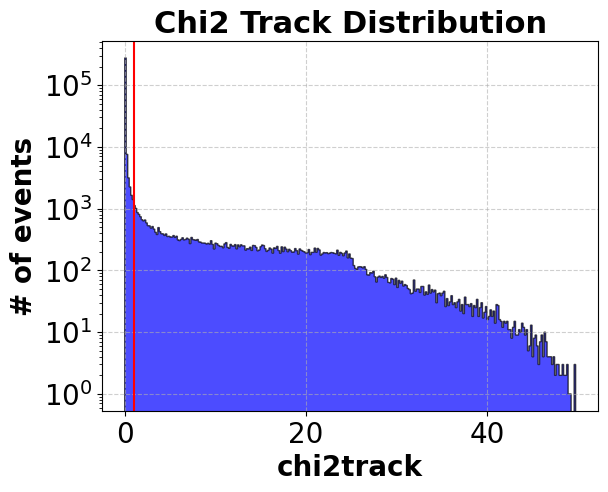

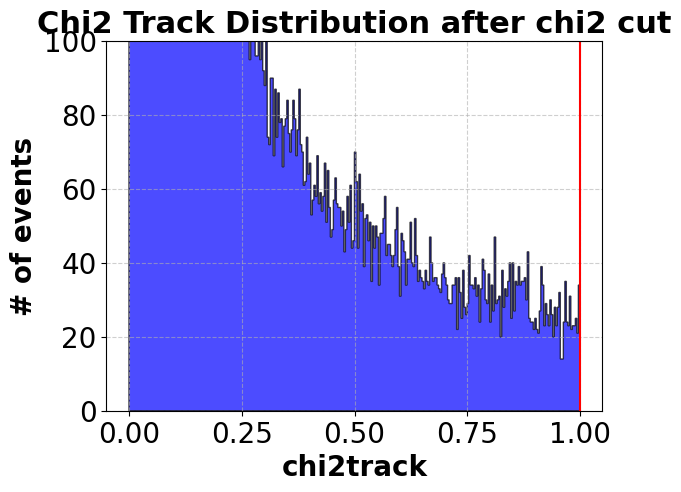

In [6]:
print(f'Start processing: {df["eventNo"].shape[0]} events')
get_best_tracks(df, channels, chi2_quality, plot=True)

In [7]:
for channel in channels:
    get_single_peak(df, channel)

In [8]:
event_start_number = get_run_event_start(df)
print(event_start_number)
# event_start, event_end = 4416, None
event_start, event_end = event_start_number, None

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

None


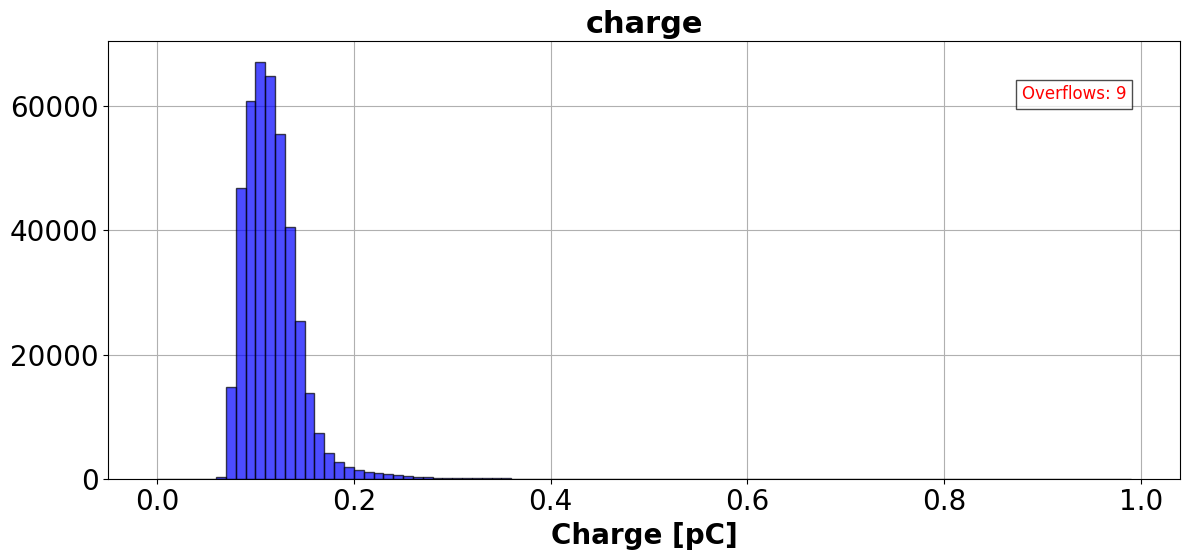

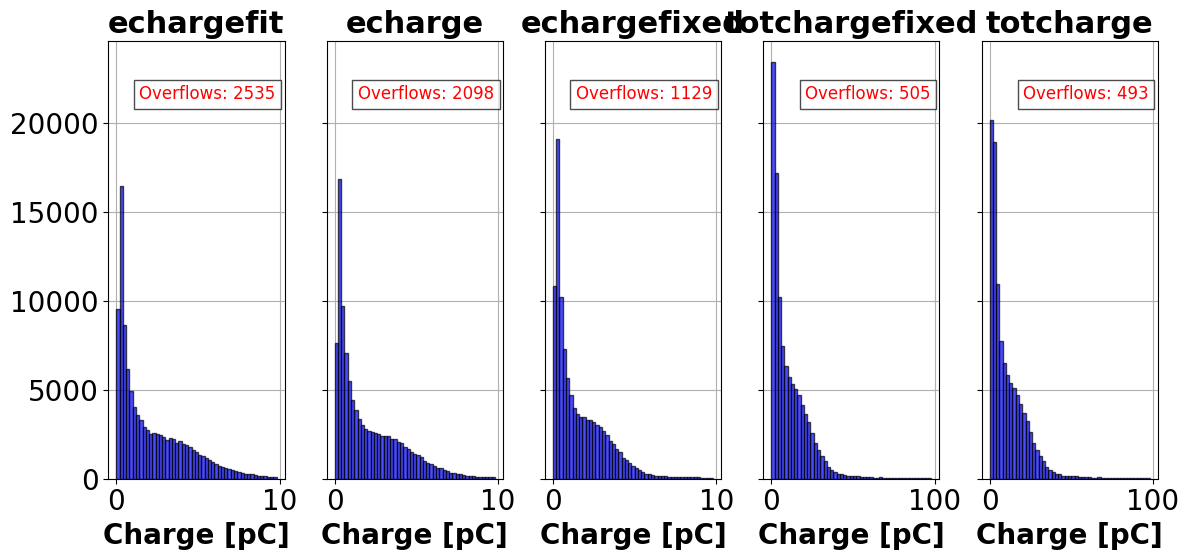

In [9]:
# Loop over channels
mcp_bins = np.arange(0, 1.0, 0.01)
ebins = np.arange(0, 10, 0.2)
totbins = np.arange(0, 100, 2)

for channel in [mcp_channel, mm_channel]:
    if channel == mcp_channel:
        charge_types = ["charge"]
    else:
        charge_types = ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]

    num_charges = len(charge_types)

    fig, axes = plt.subplots(1, num_charges, figsize=(12,6), sharey=True)

    # Ensure axes is always iterable (wrap in list if only one subplot)
    if num_charges == 1:
        axes = [axes]

    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    for i, charge_type in enumerate(charge_types):
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
        elif "echarge" in charge_type:
            filtered_data = charge_data[(charge_data > min_echarge) & (charge_data < max_echarge)]
            binning = ebins
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            if channel == mcp_channel:
                binning = mcp_bins

        n_overflows = np.sum(charge_data > binning[-1])
        axes[i].hist(filtered_data, bins=binning, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        axes[i].set_title(charge_type)
        axes[i].set_xlabel('Charge [pC]')
        axes[i].grid(True, zorder=0)
        # Add overflow text
        axes[i].text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=axes[i].transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Add a background box
        )
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.savefig(f'charge_histograms_{channel}.pdf', dpi=300)
plt.savefig(f'charge_histograms_{channel}.png', dpi=300)

/tmp/ipykernel_15307/1574921564.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(title="Charge Types")


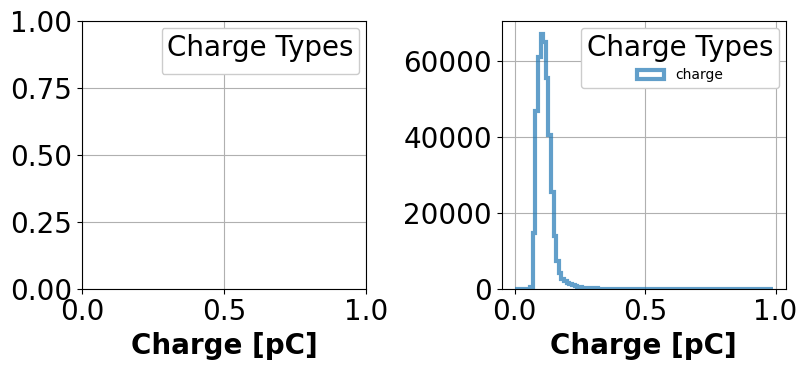

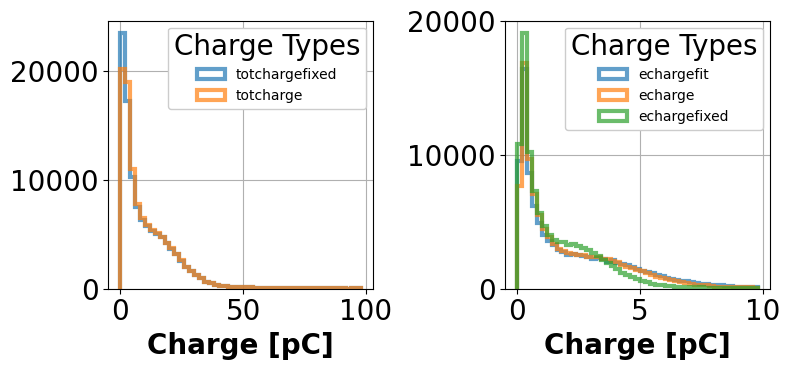

In [10]:
channel_charge_types = {
    mcp_channel: ["charge"],
    mm_channel: ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"],
}

# Loop through the channels you want to plot
for channel in channels:
    charge_types = channel_charge_types[channel]  # Select charge types based on the channel

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))  # Create figure with 2 subplots (ncols=2)

    # Loop over each charge type for the current channel
    for charge_type in charge_types:
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        # Apply filters based on the charge type (e.g., total charge vs. echarge)
        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
            ax_num = 0  # First subplot (totcharge)
        elif "echarge" in charge_type:
            filtered_data = charge_data[(charge_data > min_echarge) & (charge_data < max_echarge)]
            binning = ebins
            ax_num = 1
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            ax_num = 1  # Second subplot (echarge)
            if channel == mcp_channel:
                binning = mcp_bins  # Special binning for mcp

        # Plot the histogram
        n, bins, _ = axs[ax_num].hist(filtered_data, bins=binning, alpha=0.7, label=charge_type,
                                      zorder=2, histtype='step', linewidth=3)

        # Optional: Adding labels on top of histogram lines (bins)
        for i in range(len(bins)-1):
            # Find the position to put the label (at the middle of each bin)
            bin_center = (bins[i] + bins[i+1]) / 2
            count = n[i]  # Get the count (height) of the histogram at this bin
            # axs[ax_num].text(bin_center, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)

    # Customize the plots
    axs[0].set_xlabel('Charge [pC]')
    axs[0].grid(True)
    axs[1].set_xlabel('Charge [pC]')
    axs[1].grid(True)

    # Add legends to the subplots
    axs[0].legend(title="Charge Types")
    axs[1].legend(title="Charge Types")

    # Set title for the current channel
    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    # Adjust the layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show plot for the current channel
    plt.show()

In [11]:
time_col = 'tfit20_nb'
df[f'{mm_channel}_time_diff'] = df[f'peakparam_{mm_channel}/peakparam_{mm_channel}.{time_col}'] - df[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.{time_col}']

filters = {channel: {} for channel in channels}
for channel in channels:
    
    tot_charge_data = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
    filters[channel].update({'totcharge_cut': (tot_charge_data > min_charge_tot) & (tot_charge_data < max_charge_tot)})

    echarge_data = df[f'peakparam_{channel}/peakparam_{channel}.echarge']
    filters[channel].update({'echarge_cut': (echarge_data > min_echarge) & (echarge_data < max_echarge)})

    echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    filters[channel].update({'echargefit_cut': (echarge_fit_data > min_echarge) & (echarge_fit_data < max_echarge)})

    charge_data = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    filters[channel].update({'charge_cut': (charge_data > min_charge_tot) & (charge_data < max_charge_tot)})

    ampl_data = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    filters[channel].update({'ampl_cut': (ampl_data > min_ampl) & (ampl_data < max_ampl)})

    dampl_data = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
    filters[channel].update({'dampl_cut': (dampl_data > min_ampl) & (dampl_data < max_ampl)})
    filters[channel].update({'saturation_cut': dampl_data < mm_saturation_voltage})


    #
    # echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    # filters[channel].update({'echargefit_cut': (echarge_fit_data > min_charge) & (echarge_fit_data < max_charge)})

    x_data = df[f'hitX_{channel}']
    y_data = df[f'hitY_{channel}']
    
    xy_filter_cut = (x_data > xy_range_min) & (x_data < xy_range_max) & (y_data > xy_range_min) & (y_data < xy_range_max)
    filters[channel].update({'xy_cut': xy_filter_cut})
    
    
    
# Get filtered dataframes for each channel -- charge filter
mcp_charge_filtered_df = df[filters[mcp_channel]['charge_cut']]
mm_charge_filtered_df = df[filters[mm_channel]['totcharge_cut']]

x_mcp_filtered = mcp_charge_filtered_df[f'hitX_{mcp_channel}']
y_mcp_filtered = mcp_charge_filtered_df[f'hitY_{mcp_channel}']

C1 Number of outliers: 0 of 412778
C1 Number after filter: 412778 of 412778
C1 channel: min = 0.0015645792768780571, max = 1.2474482998406315
C2 Number of outliers: 539 of 109298
C2 Number after filter: 108759 of 109298
C2 channel: min = 0.15091765798960194, max = 99.9835630785842


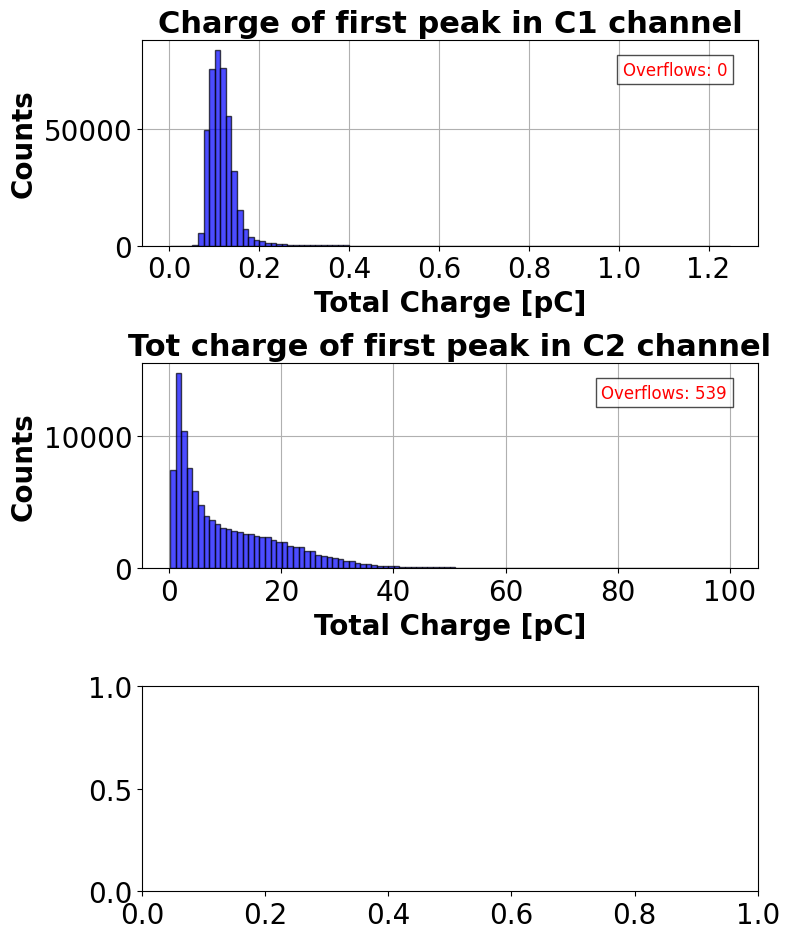

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))  # 3 rows, 1 column

for i, channel in enumerate(channels):
    # Get first charge or total charge based on the channel
    if channel == mcp_channel:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df_filter = df[filters[channel]['charge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.charge']
    else:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df_filter = df[filters[channel]['totcharge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.totcharge']

    # Convert to numpy arrays for filtering
    n_overflows = np.sum(first_charges_unfiltered < min_charge_tot) + np.sum(first_charges_unfiltered > max_charge_tot)  # Overflow count
    n_in_range = len(first_charges_filtered)
    n_total = n_in_range + n_overflows

    # Print outliers information
    print(f'{channel} Number of outliers: {n_overflows} of {n_total}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {n_total}')
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')

    # Plot each channel's charge histogram
    ax = axes[i]  # Use the appropriate axis in the grid
    ax.hist(first_charges_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)

    # Set title based on the channel
    if channel == mcp_channel:
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')

    # Set labels
    ax.set_xlabel('Total Charge [pC]')
    ax.set_ylabel('Counts')

    # Add overflow text
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    ax.grid(True, zorder=0)

# Adjust layout to avoid overlap and ensure titles fit
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap

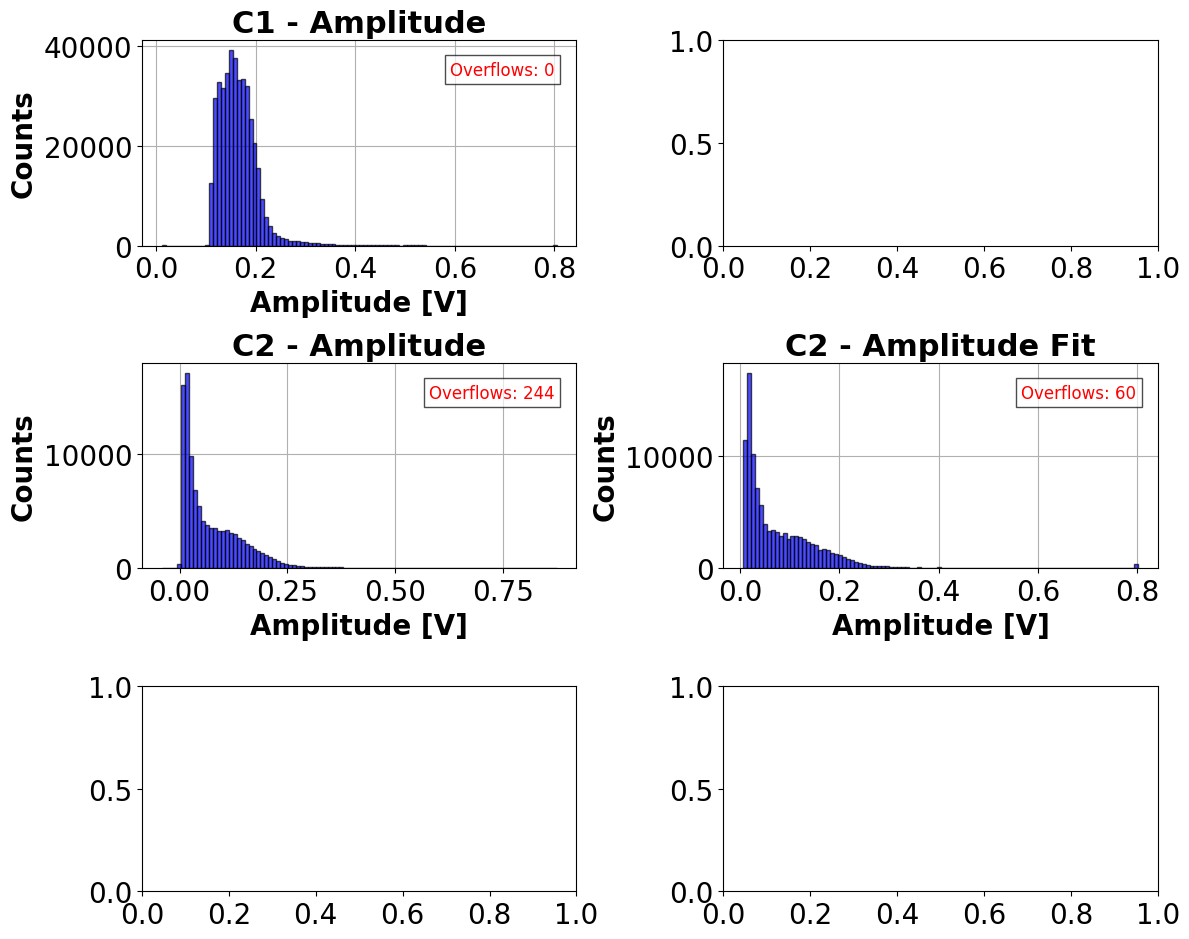

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))  # 3 rows, 2 columns

for i, channel in enumerate(channels):
    # First peak amplitude histogram
    first_ampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df_filter = df[filters[channel]['ampl_cut']]
    first_ampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.ampl']

    n_overflows = np.sum(first_ampls_unfiltered < min_ampl) + np.sum(first_ampls_unfiltered > max_ampl)  # Overflow count
    n_in_range = len(first_ampls_filtered)
    n_total = n_in_range + n_overflows

    # Plot first_ampls_filtered histogram
    ax = axes[i, 0]  # Left column
    ax.hist(first_ampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
    ax.set_title(f'{channel} - Amplitude')
    ax.set_xlabel('Amplitude [V]')
    ax.set_ylabel('Counts')
    ax.grid(True, zorder=0)

    # Add overflow text for first_ampls
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    # For C2, add the second amplitude (dampl) plot
    if channel == mm_channel:
        first_dampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
        df_filter = df[filters[channel]['dampl_cut']]
        first_dampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.dampl']

        n_overflows = np.sum(first_dampls_unfiltered < min_ampl) + np.sum(first_dampls_unfiltered > max_ampl)  # Overflow count
        n_in_range = len(first_dampls_filtered)
        n_total = n_in_range + n_overflows

        # Plot first_dampls_filtered histogram
        ax = axes[i, 1]  # Right column
        ax.hist(first_dampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        ax.set_title(f'{channel} - Amplitude Fit')
        ax.set_xlabel('Amplitude [V]')
        ax.set_ylabel('Counts')
        ax.grid(True, zorder=0)

        # Add overflow text for first_dampls
        ax.text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
        )

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap
plt.savefig('amplitude_histograms.pdf', dpi=300)

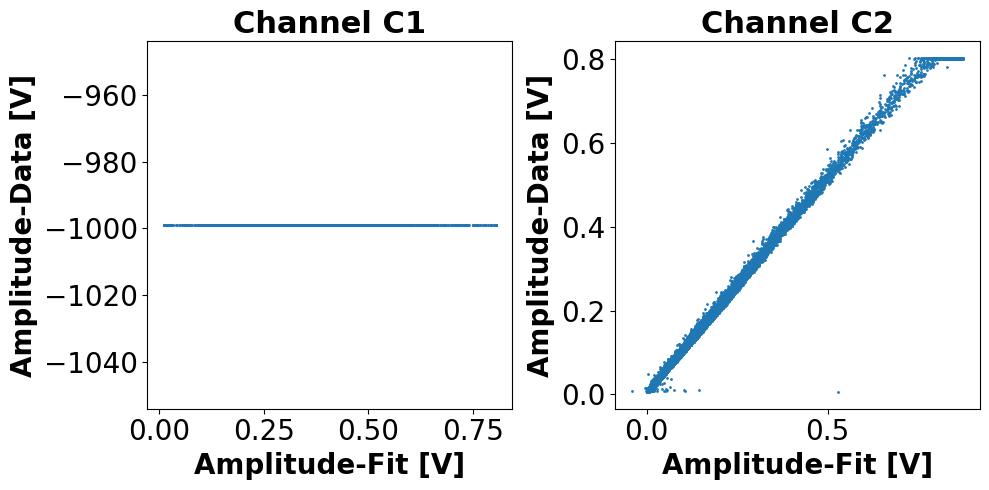

In [14]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']

    ax.scatter(ampl_filtered, dampl_filtered, s=1)
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

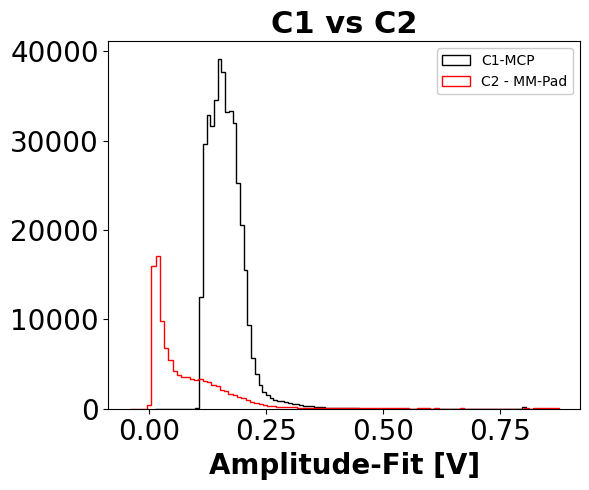

In [15]:
compare_ch_ampl = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_ampl)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(6*num_plots, 5), sharex=True, sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter MCP data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['ampl_cut']]
mcp_ampl_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.ampl']

for ax, ch in zip(axes, compare_ch_ampl):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['ampl_cut']]
    ch_ampl_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.ampl']

    # Plot histograms
    ax.hist(mcp_ampl_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    ax.hist(ch_ampl_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch} - MM-Pad')

    # Set title and legend
    ax.set_title(f'C1 vs {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.legend()

plt.tight_layout()

1
(2,)
[array([<Axes: >, <Axes: >], dtype=object)]


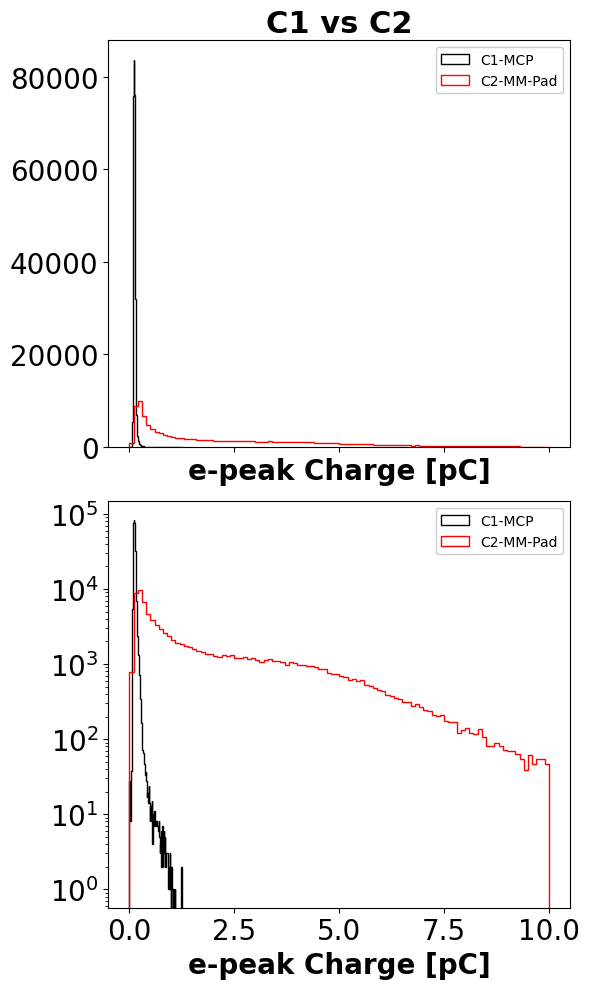

In [16]:
# Get all channels except C1
compare_ch_charge = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_charge)
print(num_plots)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)
print(axes.shape)

if num_plots == 1:
    axes = [axes]# Ensure `axes` is iterable when there's only one subplot
    print(axes)
# Filter C1 data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['charge_cut']]
mcp_ch_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.charge']

for col, ch in enumerate(compare_ch_charge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['echargefit_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # Linear scale histogram (first row)
    axes[col][0].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][0].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][0].set_title(f'C1 vs {ch}')
    axes[col][0].set_xlabel('e-peak Charge [pC]')
    axes[col][0].legend()

    # Log scale histogram (second row)
    axes[col][1].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][1].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][1].set_yscale('log')  # Set log scale for y-axis
    axes[col][1].set_xlabel('e-peak Charge [pC]')
    axes[col][1].legend()

plt.tight_layout()

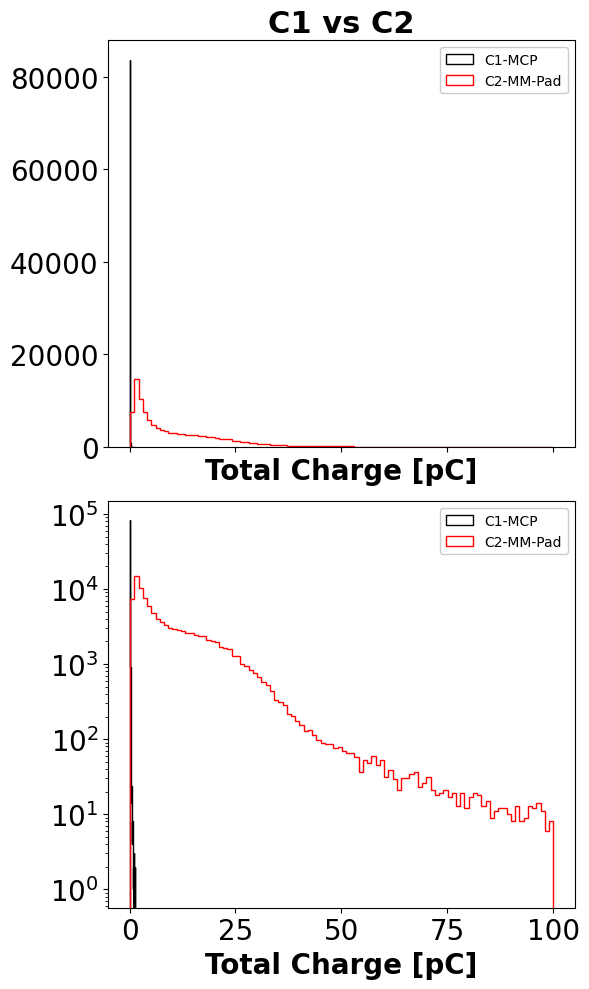

In [17]:
# Get all channels except C1
compare_ch_totcharge = [ch for ch in filters.keys() if ch != mcp_channel]

num_plots = len(compare_ch_totcharge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_mcp = df[filters[mcp_channel]['charge_cut']]
mcp_ch_filtered = df_filter_mcp[f'peakparam_{mcp_channel}/peakparam_{mcp_channel}.charge']

for col, ch in enumerate(compare_ch_totcharge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['totcharge_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    # Linear scale histogram (first row)
    axes[col][0].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][0].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][0].set_title(f'C1 vs {ch}')
    axes[col][0].set_xlabel('Total Charge [pC]')
    axes[col][0].legend()

    # Log scale histogram (second row)
    axes[col][1].hist(mcp_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[col][1].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[col][1].set_yscale('log')  # Set log scale for y-axis
    axes[col][1].set_xlabel('Total Charge [pC]')
    axes[col][1].legend()

plt.tight_layout()

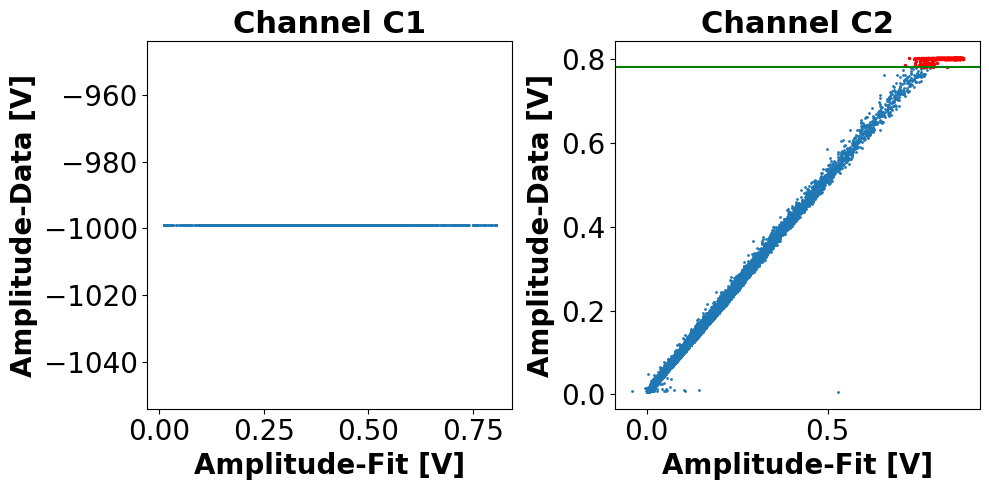

In [18]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']


    df_filter_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    ampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_saturation = df_filter_saturation[f'peakparam_{ch}/peakparam_{ch}.dampl']



    ax.scatter(ampl_filtered, dampl_filtered, s=1)

    if ch != mcp_channel:
        ax.scatter(ampl_saturation, dampl_saturation, s=2, color='red', label=f'Saturation {mm_channel}')
        ax.axhline(mm_saturation_voltage, color='green', linestyle='-', label='Saturation Voltage')

    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

1


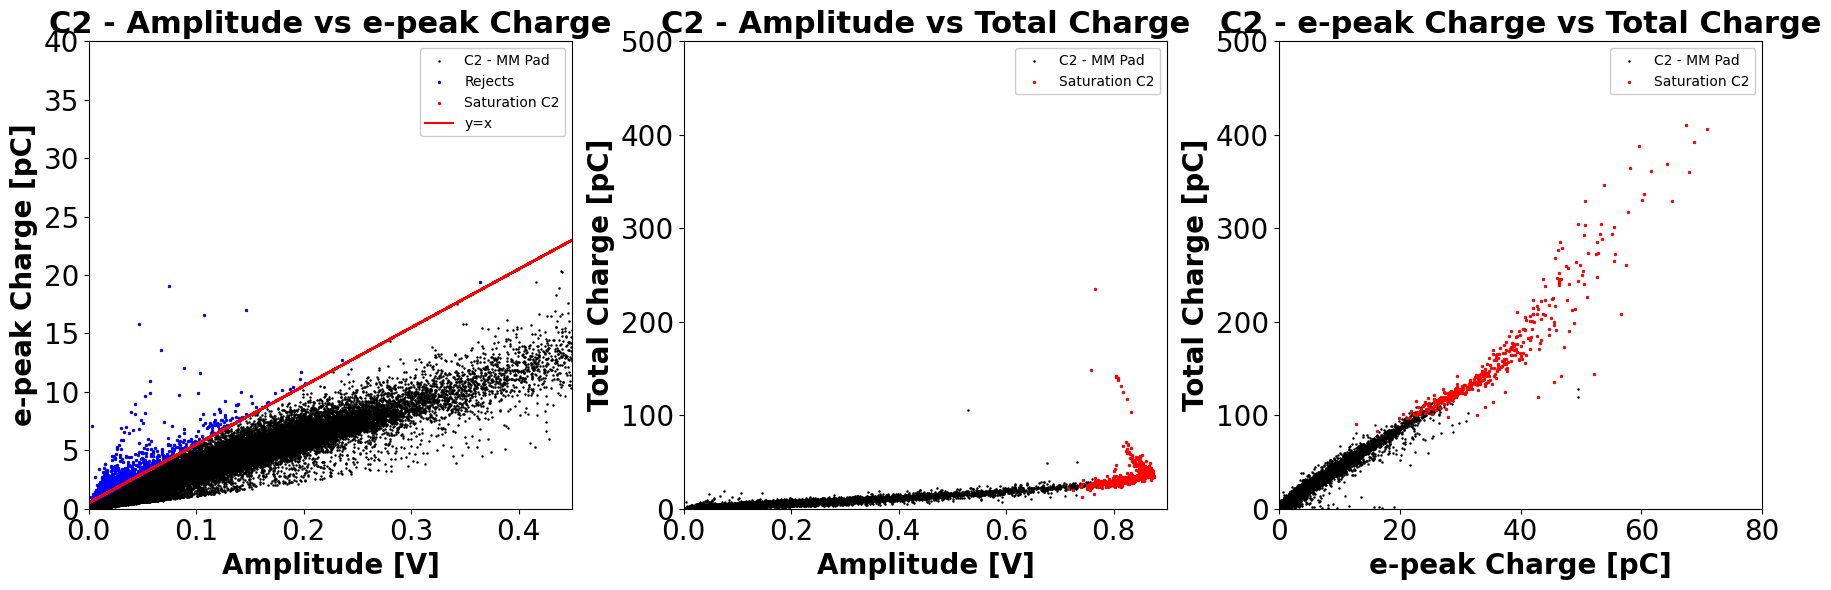

In [19]:
channels = [ch for ch in filters.keys() if ch != mcp_channel]
num_channels = len(channels)
print(num_channels)

fig, axs = plt.subplots(nrows=num_channels, ncols=3, figsize=(18, 6*num_channels), sharex=False, sharey=False)

if num_channels == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one channel

# Loop over each channel
for row, ch in enumerate(channels):
    df_filter = df[filters[ch]['ampl_cut']]

    # Extract data
    x_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']


    df_saturation = df[filters[ch]['ampl_cut'] & ~filters[ch]['saturation_cut']]
    x_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_saturation = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']



    # First scatter plot (Amplitude vs e-peak Charge with rejection line)
    up_slope, up_offset = 50, 0.5
    up_rejects_filter = y_filtered > line(x_filtered, up_slope, up_offset)
    up_rejects_x = x_filtered[up_rejects_filter]
    up_rejects_y = y_filtered[up_rejects_filter]

    axs[row][0].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][0].scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label='Rejects')
    axs[row][0].scatter(x_saturation, y_saturation, s=2, color='red', label=f'Saturation {mm_channel}')
    axs[row][0].plot(np.array(x_filtered), line(np.array(x_filtered), up_slope, up_offset), color='red', label='y=x')

    axs[row][0].set_xlabel('Amplitude [V]')
    axs[row][0].set_ylabel('e-peak Charge [pC]')
    axs[row][0].set_xlim(0, 0.45)
    axs[row][0].set_ylim(0, 40)
    axs[row][0].legend()
    axs[row][0].set_title(f'{ch} - Amplitude vs e-peak Charge')

    # Second scatter plot (Amplitude vs Total Charge)
    axs[row][1].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][1].scatter(x_saturation, y_saturation, s=2, color='red', label=f'Saturation {mm_channel}')

    axs[row][1].set_xlabel('Amplitude [V]')
    axs[row][1].set_ylabel('Total Charge [pC]')
    axs[row][1].set_xlim(0, 0.9)
    axs[row][1].set_ylim(0, 500)
    axs[row][1].legend()
    axs[row][1].set_title(f'{ch} - Amplitude vs Total Charge')

    # Third scatter plot (e-peak Charge vs Total Charge)
    x_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    x_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_saturation_2 = df_saturation[f'peakparam_{ch}/peakparam_{ch}.totcharge']


    axs[row][2].scatter(x_filtered_2, y_filtered_2, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row][2].scatter(x_saturation_2, y_saturation_2, s=2, color='red', label=f'Saturation {mm_channel}')
    axs[row][2].set_xlabel('e-peak Charge [pC]')
    axs[row][2].set_ylabel('Total Charge [pC]')
    axs[row][2].set_xlim(0, 80)
    axs[row][2].set_ylim(0, 500)
    axs[row][2].legend()
    axs[row][2].set_title(f'{ch} - e-peak Charge vs Total Charge')

plt.tight_layout()
plt.show()

# Get the pad center using the charge weighted method

bin_x_min: 2.1440200805664062, bin_x_max: 99.68235778808594
bin_y_min: 2.4024269580841064, bin_y_max: 99.50904846191406


(None, None)

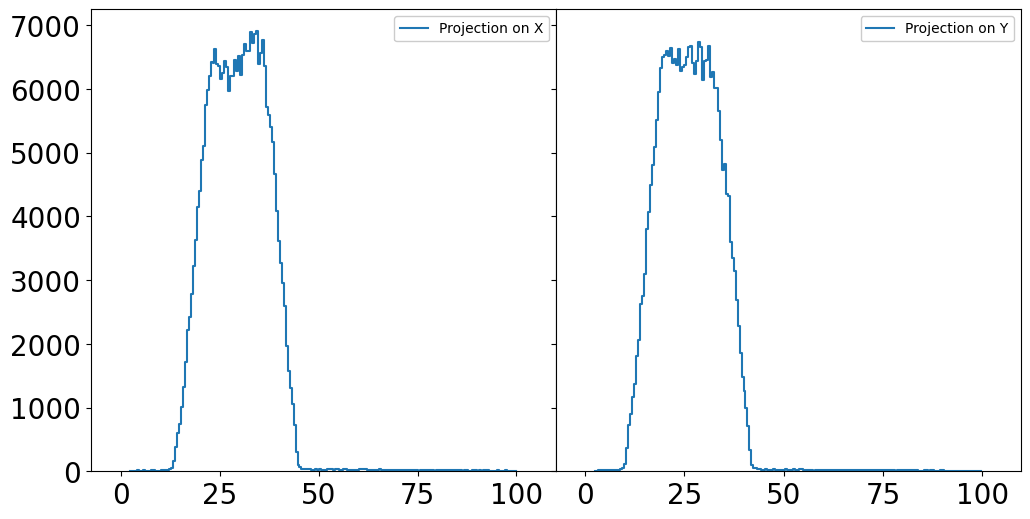

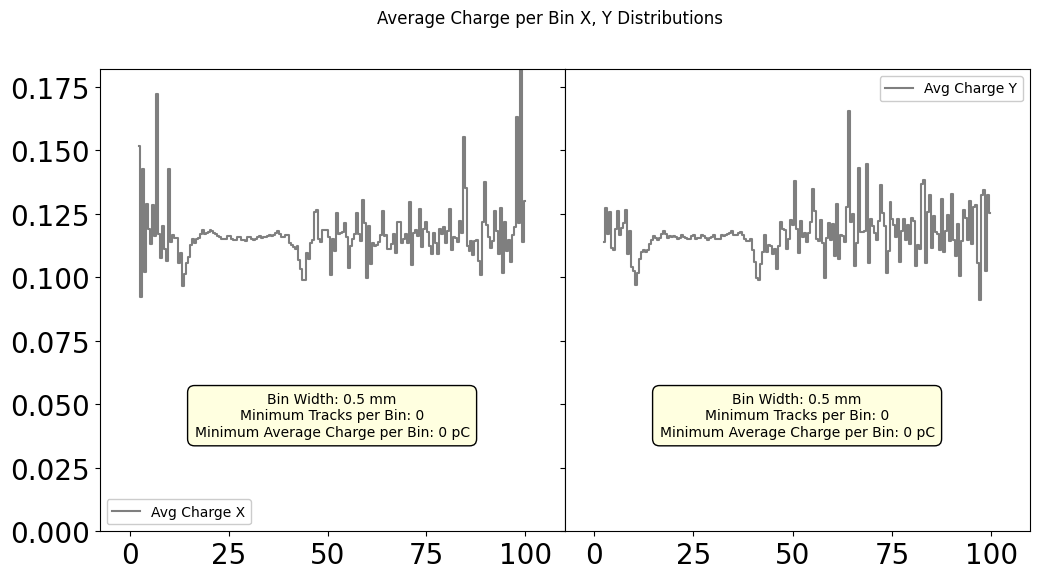

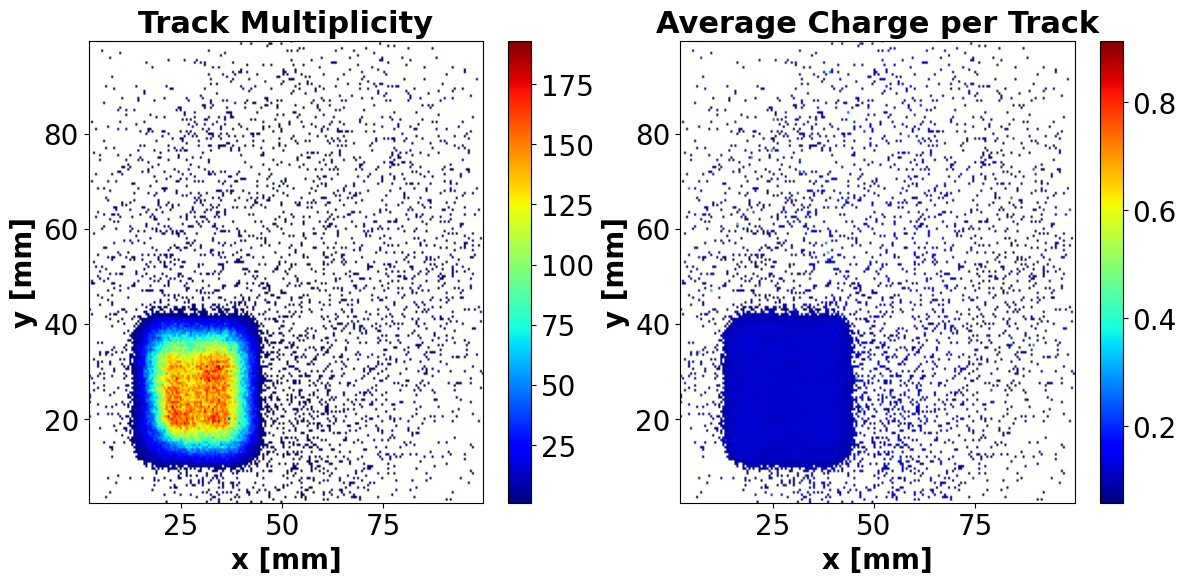

In [20]:
channel = mcp_channel
df_filter = df[filters[channel]['charge_cut'] & filters[channel]['xy_cut']]
xs_mcp_filtered = df_filter[f'hitX_{channel}']
ys_mcp_filtered = df_filter[f'hitY_{channel}']
charges_mcp_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.charge']
get_pad_center(charges_mcp_filtered, xs_mcp_filtered, ys_mcp_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot=True, plot_only=True)

bin_x_min: 2.1440200805664062, bin_x_max: 99.68235778808594
bin_y_min: 2.4024269580841064, bin_y_max: 99.50904846191406


/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:333: RuntimeWarning: invalid value encountered in divide
  avg_x_charge_err = np.where(sum_x_tracks > 0, np.abs(avg_x_charge) / np.sqrt(sum_x_tracks), 1)
/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:335: RuntimeWarning: invalid value encountered in divide
  avg_y_charge_err = np.where(sum_y_tracks > 0, np.abs(avg_y_charge) / np.sqrt(sum_y_tracks), 1)


C1 Pad Center: (28.43 ± 0.37, 26.83 ± 0.38)


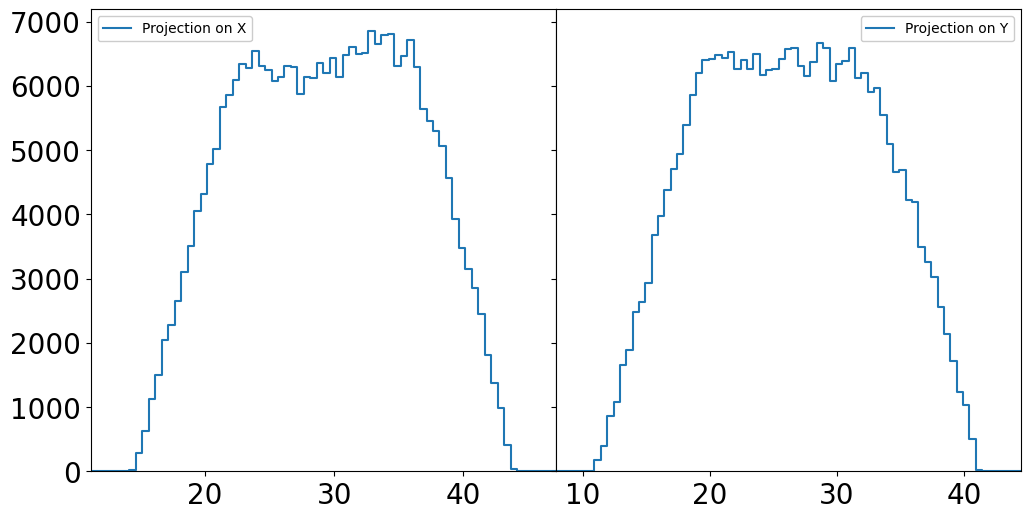

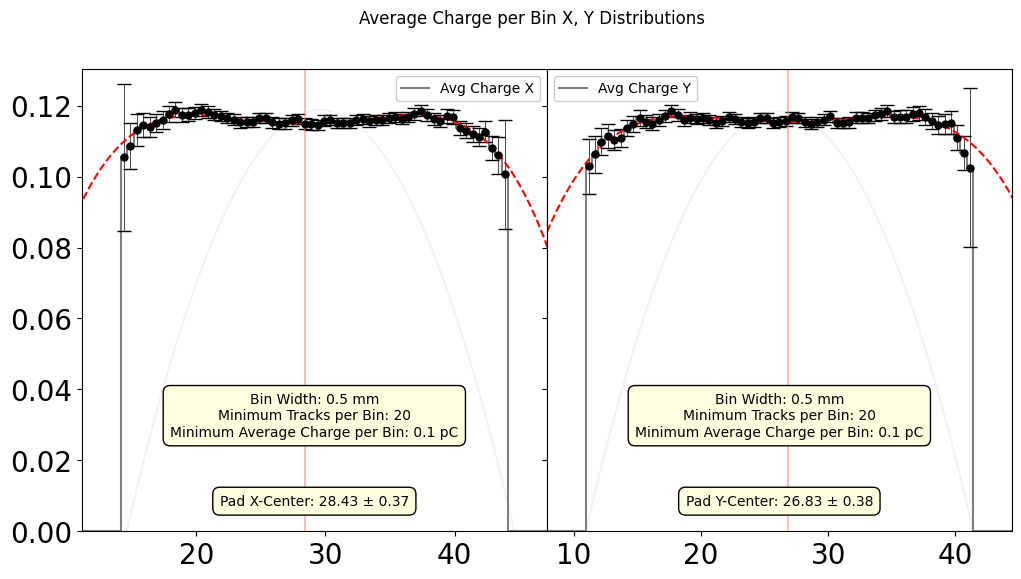

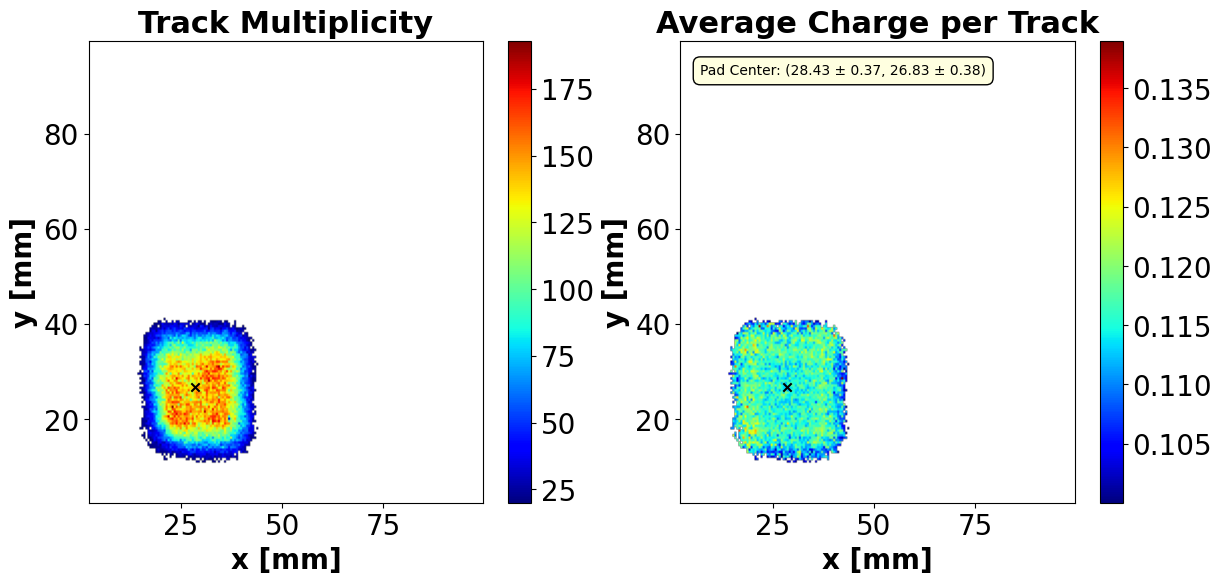

In [21]:
mcp_pad_center_measures = get_pad_center(charges_mcp_filtered, xs_mcp_filtered, ys_mcp_filtered, min_avg_charge_per_2d_bin=0.1, plot=True, plot_only=False)
print(f'C1 Pad Center: ({", ".join([str(xi) for xi in mcp_pad_center_measures])})')

bin_x_min: 2.616230010986328, bin_x_max: 99.04225158691406
bin_y_min: 2.6352343559265137, bin_y_max: 99.48856353759766


(None, None)

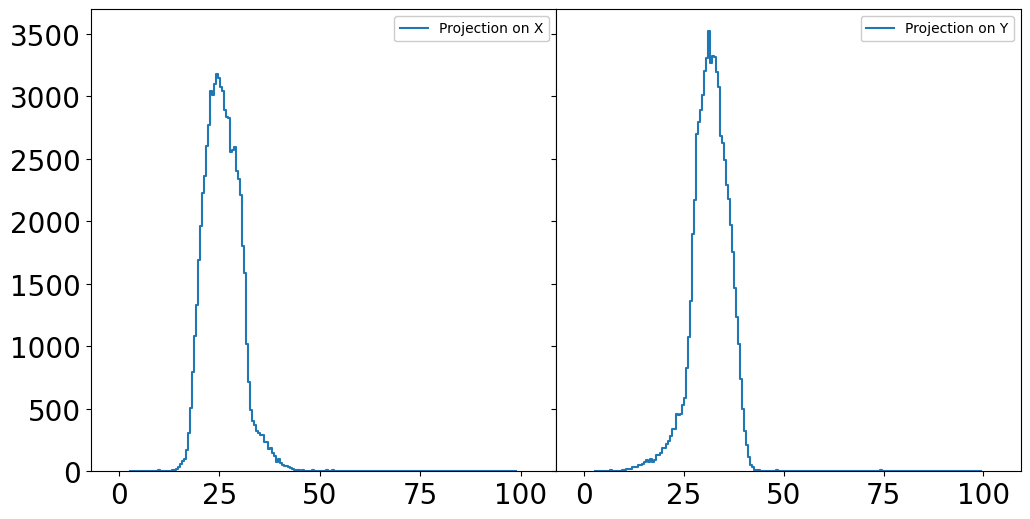

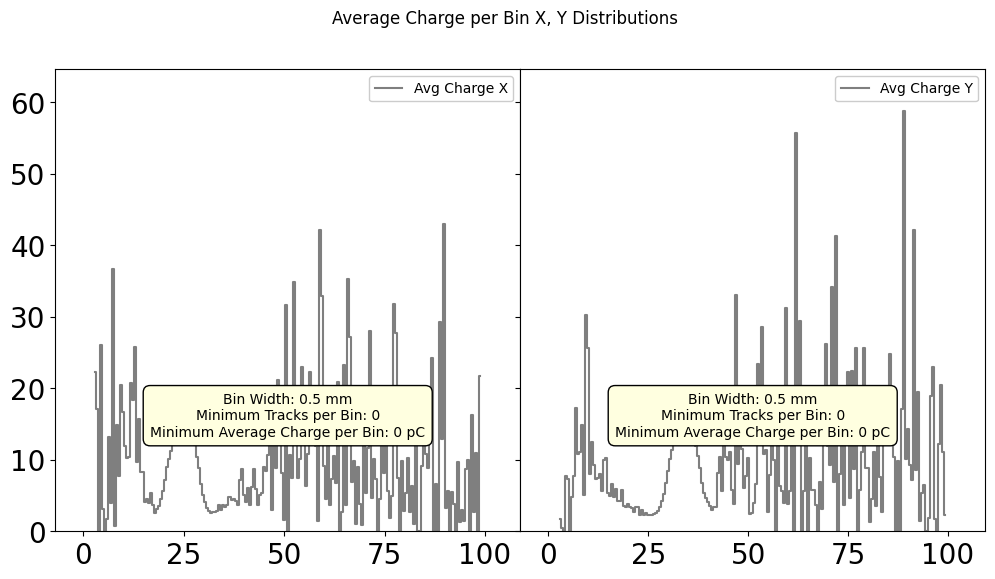

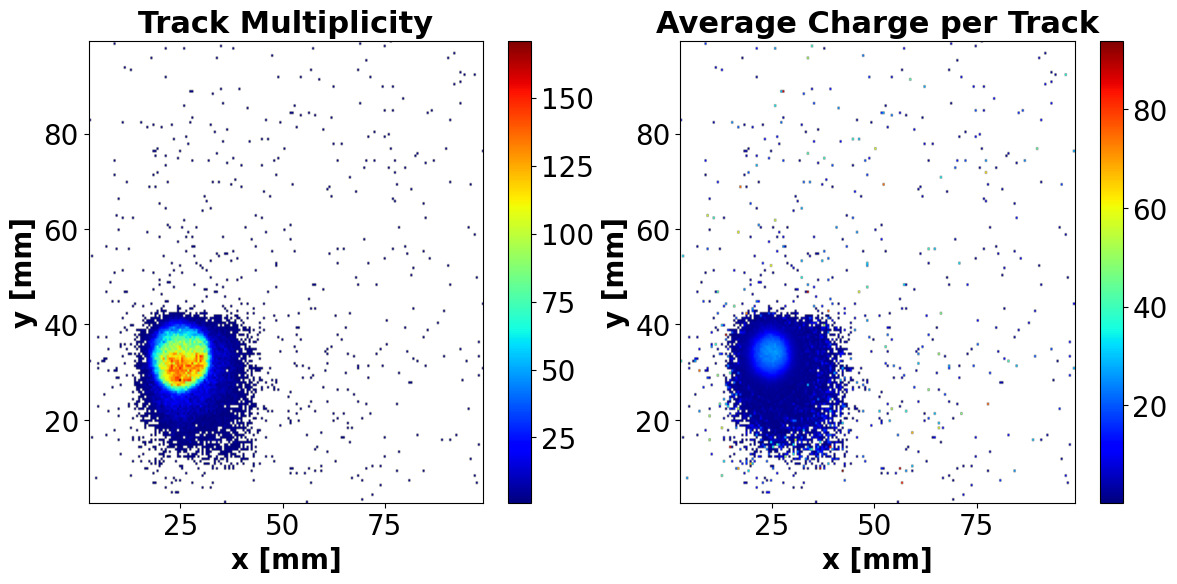

In [22]:
df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['xy_cut'] & filters[mm_channel]['saturation_cut']]
xs_mm_filtered = df_filter[f'hitX_{mm_channel}']
ys_mm_filtered = df_filter[f'hitY_{mm_channel}']
charges_mm_filtered = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
get_pad_center(charges_mm_filtered, xs_mm_filtered, ys_mm_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot=True, plot_only=True)


bin_x_min: 2.616230010986328, bin_x_max: 99.04225158691406
bin_y_min: 2.6352343559265137, bin_y_max: 99.48856353759766
C2 Pad Center: (24.827 ± 0.037, 34.061 ± 0.046)


/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:333: RuntimeWarning: invalid value encountered in divide
  avg_x_charge_err = np.where(sum_x_tracks > 0, np.abs(avg_x_charge) / np.sqrt(sum_x_tracks), 1)
/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:335: RuntimeWarning: invalid value encountered in divide
  avg_y_charge_err = np.where(sum_y_tracks > 0, np.abs(avg_y_charge) / np.sqrt(sum_y_tracks), 1)


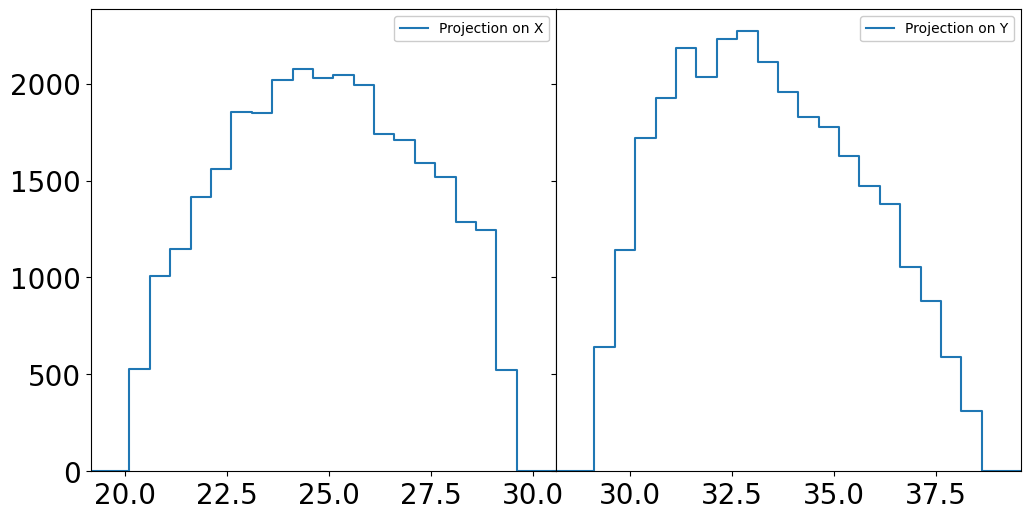

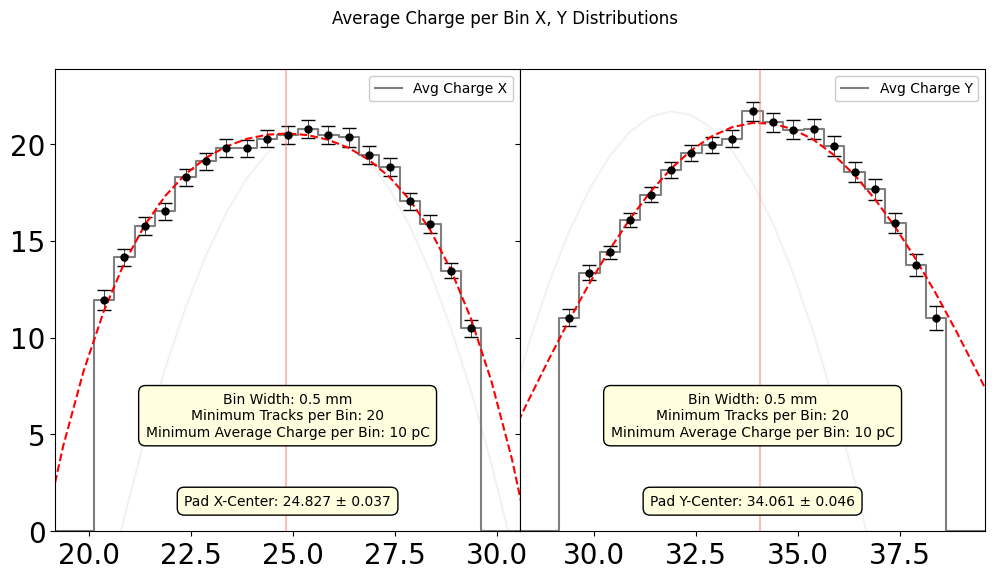

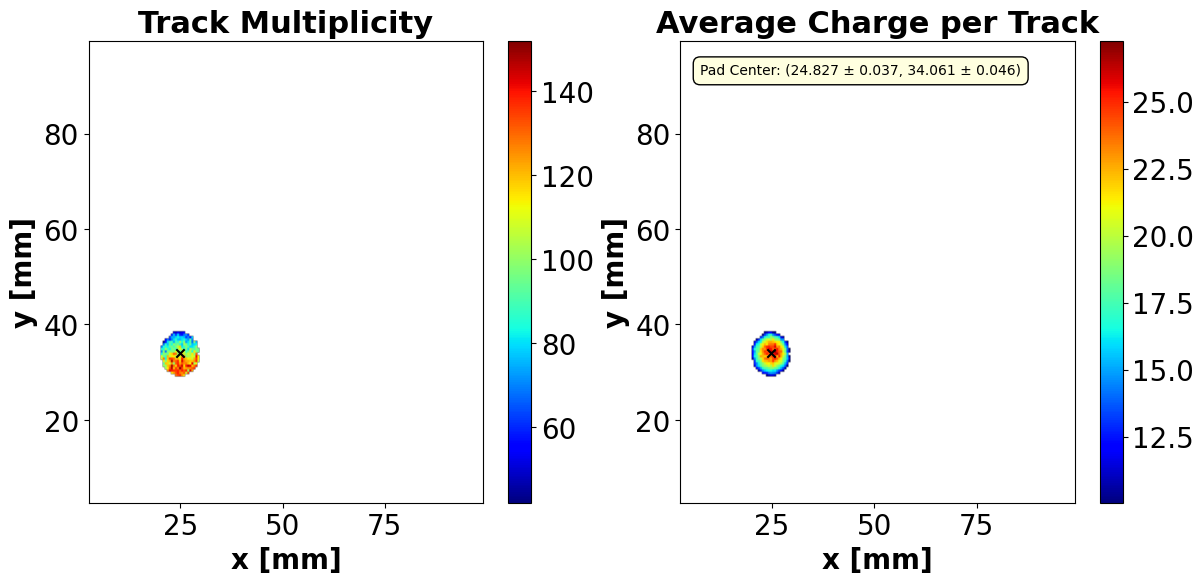

In [23]:
mm_pad_center_measures = get_pad_center(charges_mm_filtered, xs_mm_filtered, ys_mm_filtered, min_avg_charge_per_2d_bin=10, plot=True)
print(f'{mm_channel} Pad Center: ({", ".join([str(xi) for xi in mm_pad_center_measures])})')

df[f'hitR_{mm_channel}'] = np.sqrt((df[f'hitX_{mm_channel}'] - mm_pad_center_measures[0].val) ** 2 + (df[f'hitY_{mm_channel}'] - mm_pad_center_measures[1].val) ** 2)
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
filters[mm_channel].update({'r_cut': df[f'hitR_{mm_channel}'] < r_outer})

# Get the time walk parameterization raw data

n_event_bins: 724


/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:462: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:462: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c


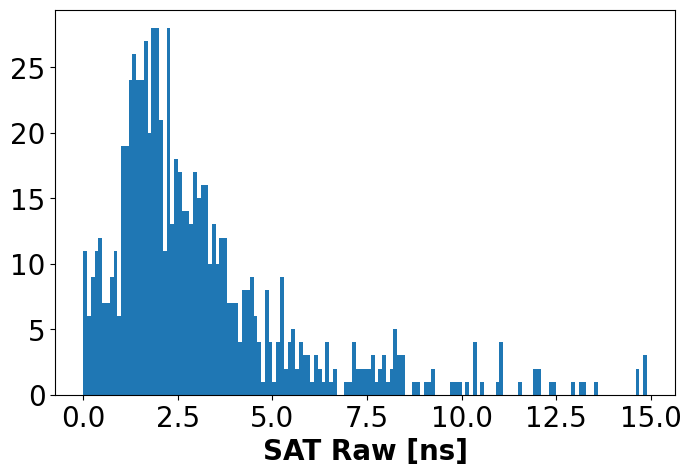

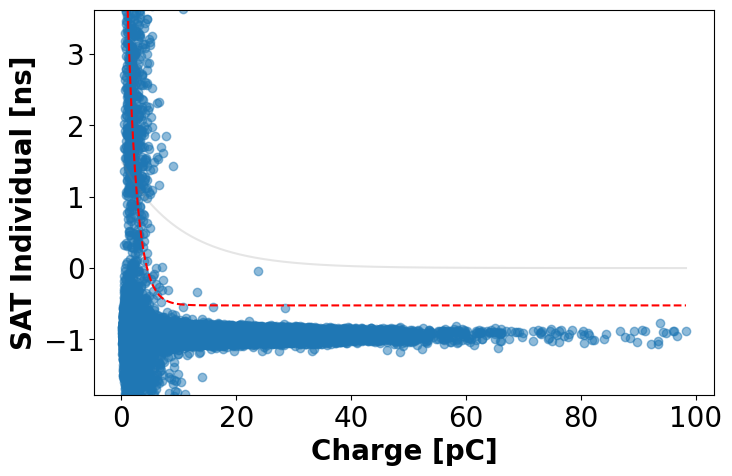

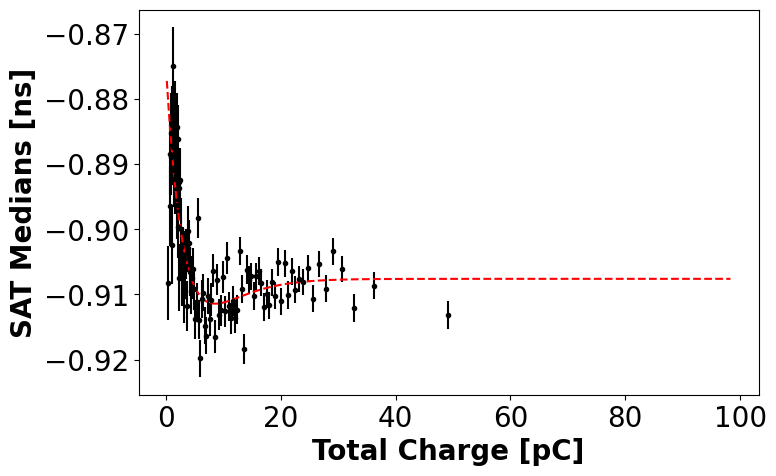

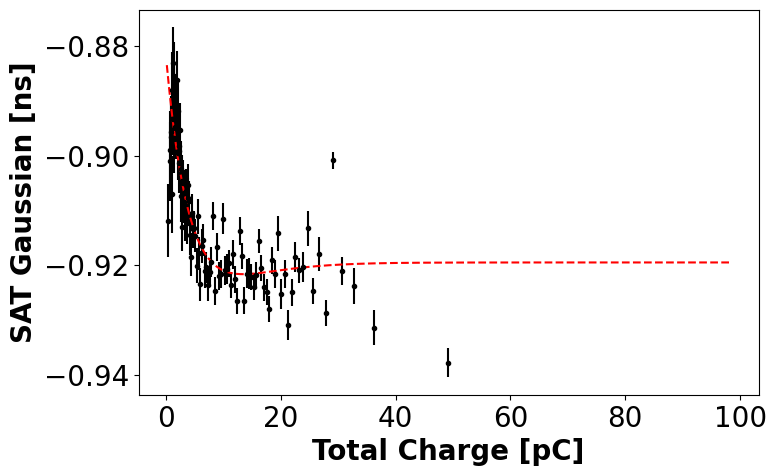

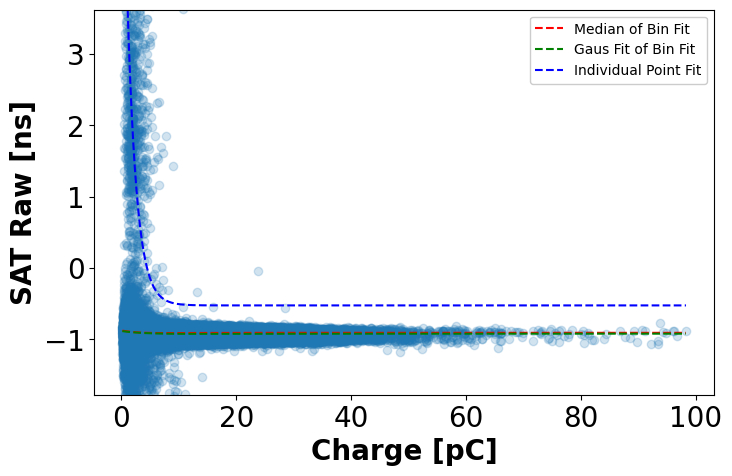

In [24]:
df_filter = df[(filters[mm_channel]['totcharge_cut']) & (filters[mm_channel]['xy_cut'])]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']

time_walk_func = time_walk_double_exponential
p0 = [1.0, -0.1, 0.5, -0.1, 0] #ampl1, decay1, amp2, decay2, bsl

indiv_params, med_bins_params, gaus_bins_params = get_time_walk(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

(array([17., 20., 19., 16., 17., 38., 50., 48., 47., 56., 32., 41., 35.,
        28., 30., 31., 26., 23., 24., 14., 11., 16., 15.,  5., 12.,  5.,
        11.,  9.,  6.,  6.,  4.,  3.,  5.,  2.,  1.,  5.,  4.,  4.,  4.,
         5.,  3.,  8.,  3.,  1.,  1.,  2.,  2.,  0.,  1.,  2.,  1.,  4.,
         1.,  0.,  1.,  4.,  0.,  1.,  0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7c753c560910>])

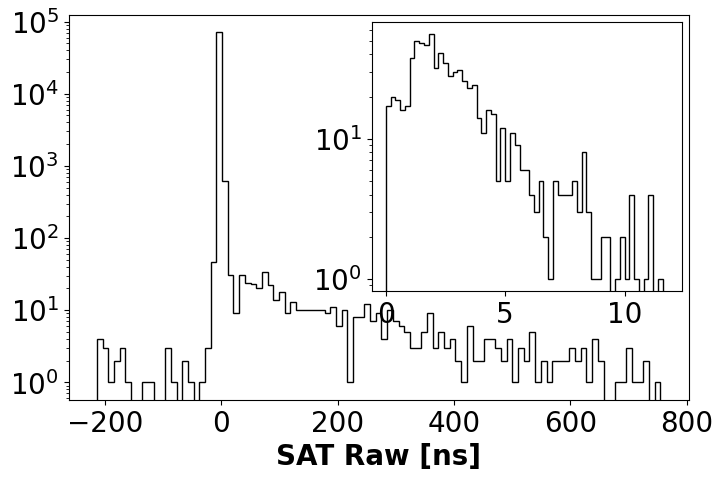

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff), np.max(time_diff), 100)
ax.hist(time_diff, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper right")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
# ax_inset.axvline(2.5, color='red', ls='-')
# ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# Time walk parameterization with radial cut

In [26]:
df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['xy_cut'] & filters[mm_channel]['r_cut'] & filters[mm_channel]['saturation_cut']]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']
xs = df_filter[f'hitX_{mm_channel}']
ys = df_filter[f'hitY_{mm_channel}']
rs = df_filter[f'hitR_{mm_channel}']

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8]),
 [<matplotlib.patches.Polygon at 0x7c75106dc400>])

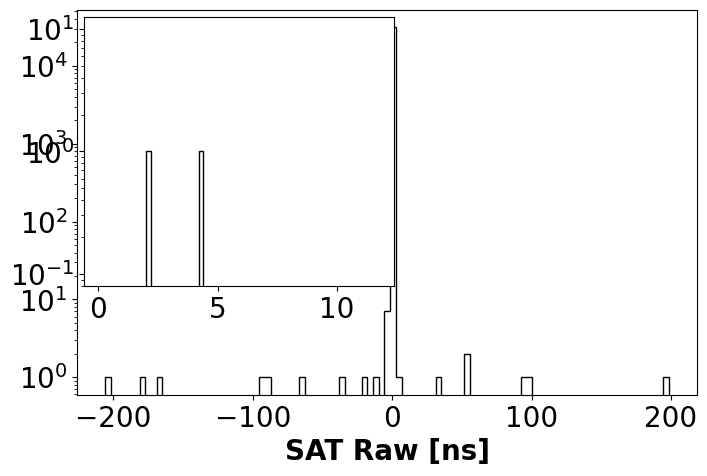

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.linspace(np.min(time_diff), np.max(time_diff), 100)
ax.hist(time_diff, bins=binning_t20_diff, histtype='step', color='black')
#make y-axis log scale
ax.set_yscale('log')
ax.set_xlabel('SAT Raw [ns]')

# Create an inset axis
ax_inset = inset_axes(ax, width="50%", height="70%", loc="upper left")  # % of parent axis

# Inset plot data
binning_t20_diff_nom = np.arange(0, 12, 0.2)
# ax_inset.axvline(2.5, color='red', ls='-')
# ax_inset.axvline(4.3, color='red', ls='-')
ax_inset.set_yscale('log')
ax_inset.hist(time_diff, bins=binning_t20_diff_nom, histtype='step', color='black')

# Check outliers in the time difference with their track position

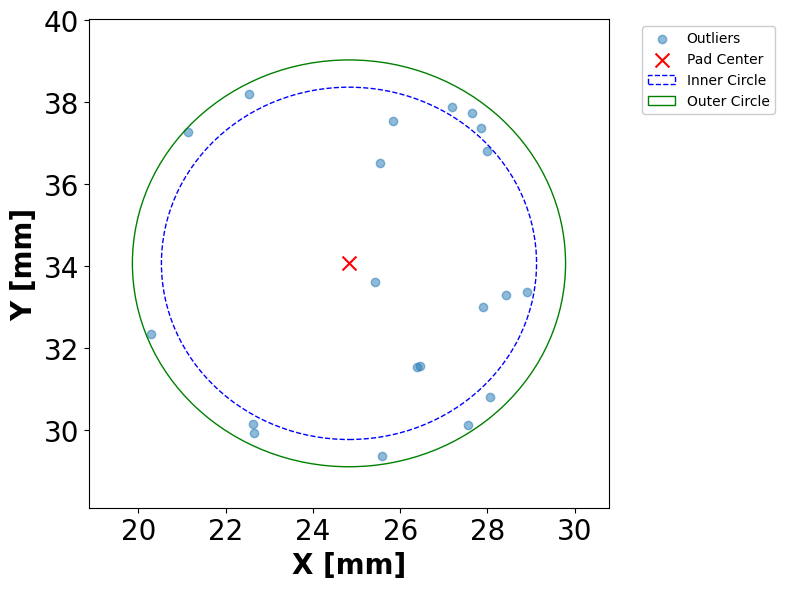

In [32]:
# time_diff_mask = (time_diff < 2.5) | ( time_diff > 4.3)
time_diff_mask = (time_diff < -2) | ( time_diff > 2)
# print(time_diff_mask)
# small_time_diff_mask = time_diff_filter < 2.5
# local_time_diff_mask = np.abs(time_diff_filter) > 4.3 or 7.5

xs_large_time_diff = xs[time_diff_mask]
ys_large_time_diff = ys[time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_large_time_diff, ys_large_time_diff, alpha=0.5, label='Outliers')
ax.scatter(mm_pad_center_measures[0].val, mm_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = mm_pad_center_measures[0].val, mm_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

n_event_bins: 313


/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:462: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c


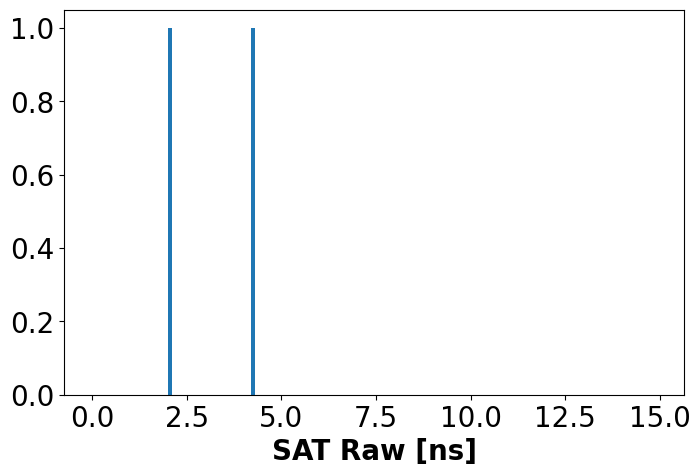

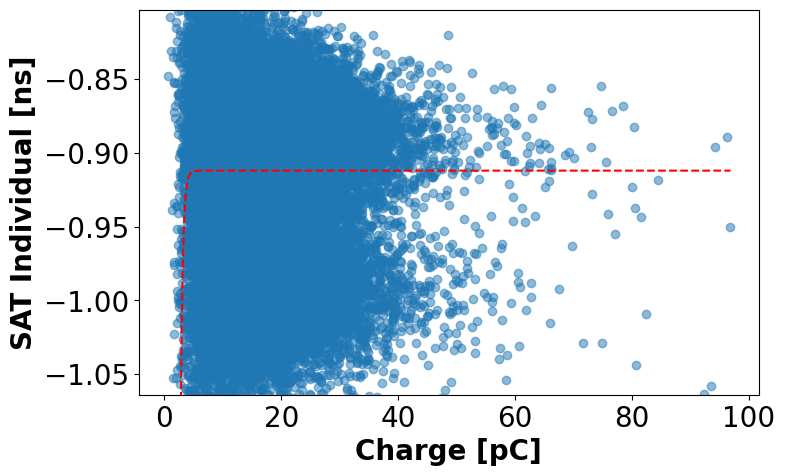

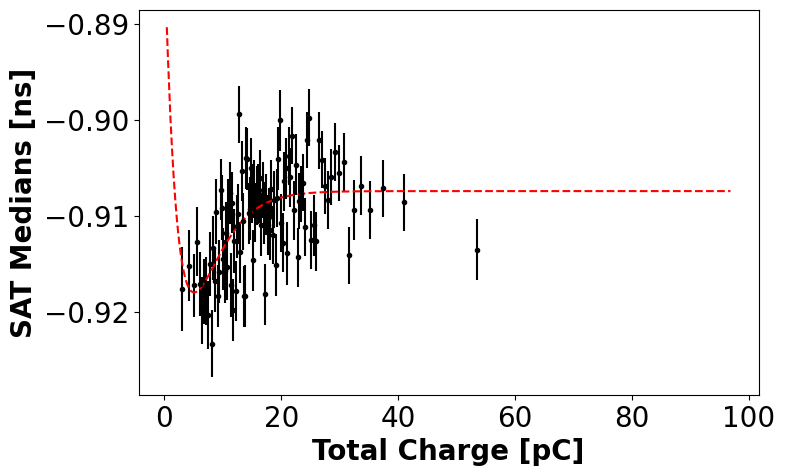

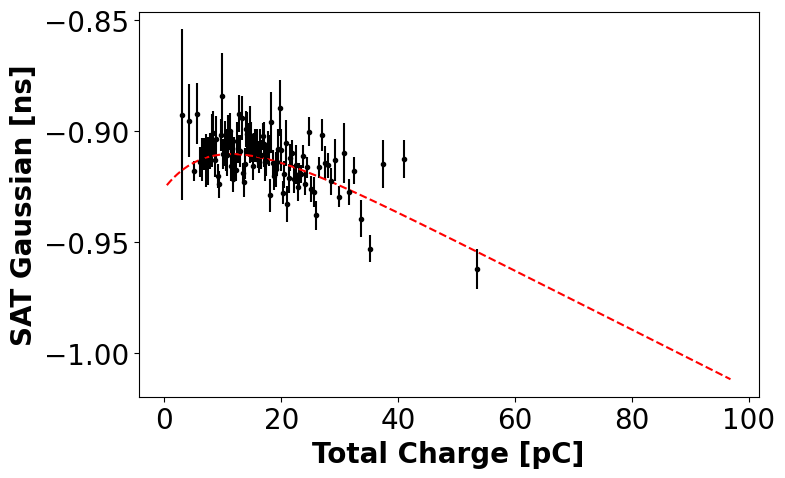

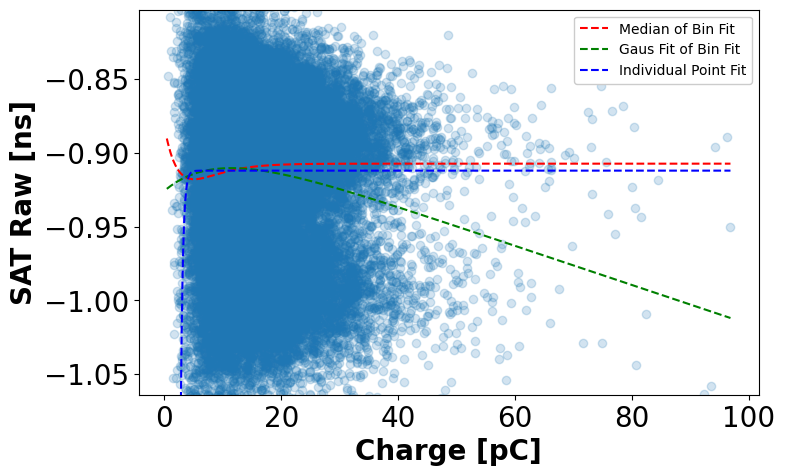

In [29]:
indiv_params, med_bins_params, gaus_bins_params = get_time_walk(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), plot=True, plot_indiv_fits=False)

Only one event in bin 65 (63.09 pC to 64.05 pC)
Only one event in bin 69 (66.95 pC to 67.91 pC)
Only one event in bin 70 (67.91 pC to 68.87 pC)
Only one event in bin 72 (69.84 pC to 70.80 pC)
Only one event in bin 73 (70.80 pC to 71.77 pC)
Only one event in bin 74 (71.77 pC to 72.73 pC)
No events in bin 76 (73.70 pC to 74.66 pC)
Only one event in bin 79 (76.59 pC to 77.55 pC)
Only one event in bin 80 (77.55 pC to 78.52 pC)
No events in bin 81 (78.52 pC to 79.48 pC)
No events in bin 85 (82.38 pC to 83.34 pC)
No events in bin 86 (83.34 pC to 84.30 pC)
Only one event in bin 87 (84.30 pC to 85.27 pC)
No events in bin 88 (85.27 pC to 86.23 pC)
No events in bin 89 (86.23 pC to 87.20 pC)
No events in bin 90 (87.20 pC to 88.16 pC)
No events in bin 91 (88.16 pC to 89.13 pC)
No events in bin 92 (89.13 pC to 90.09 pC)
No events in bin 93 (90.09 pC to 91.06 pC)
No events in bin 94 (91.06 pC to 92.02 pC)
No events in bin 95 (92.02 pC to 92.98 pC)
No events in bin 96 (92.98 pC to 93.95 pC)
Only one 

/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:462: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c
/home/dylan/PycharmProjects/pico_py_analysis/single_pad_analysis/analysis_functions.py:462: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(l1 * x) + a2 * np.exp(l2 * x) + c


val: -0.9083147065984203, err: 0.0005440730338572841


([-156 ± 291820680, -3 ± 2682, -179 ± 291820681, -3 ± 2319, -0.912 ± 0.013],
 [0.27 ± 0.22, -0.58 ± 0.33, -0.12 ± 0.27, -0.31 ± 0.17, -0.90831 ± 0.00054],
 [-2 ± 3792, -0.2 ± 7.2, 2 ± 3792, -0.2 ± 6.9, -0.9202 ± 0.0027])

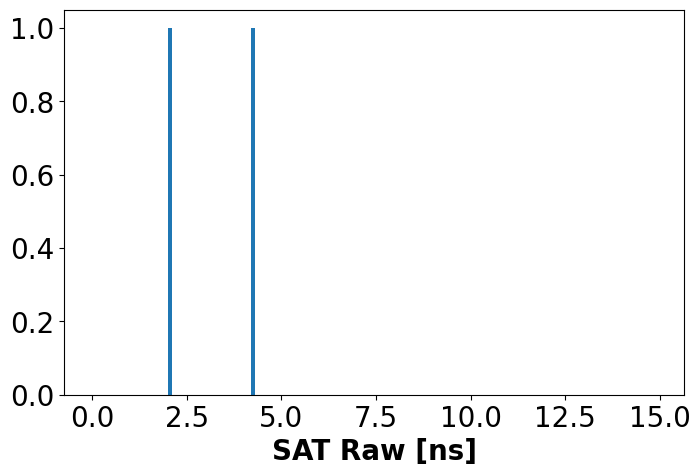

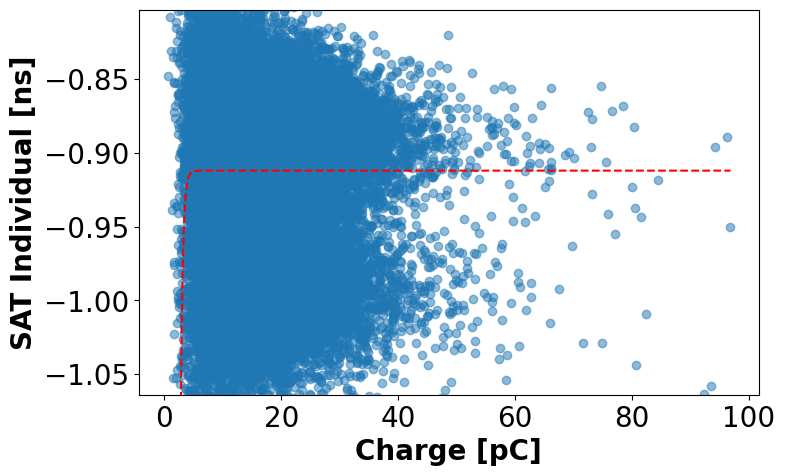

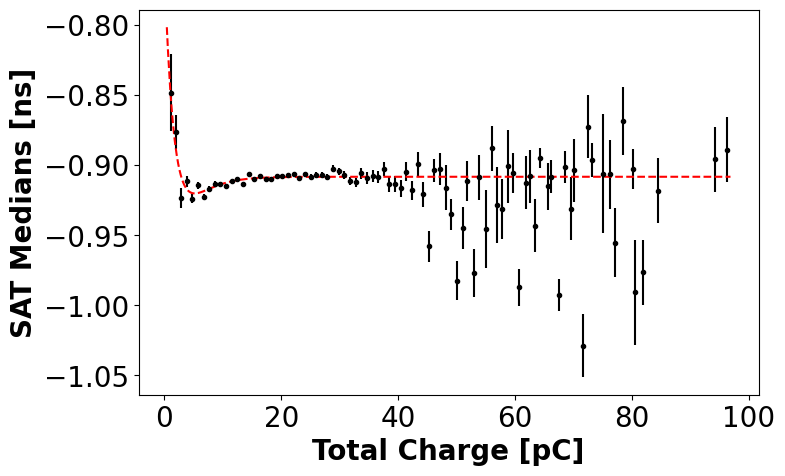

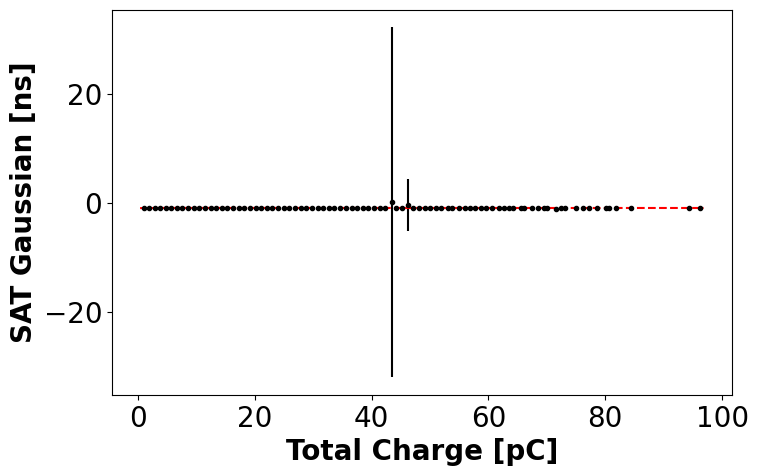

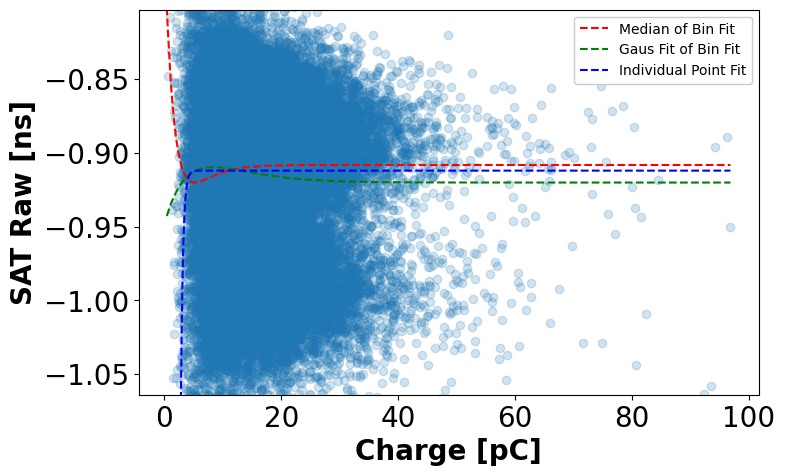

In [30]:
# indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), binning_type='equal_steps', plot=True, plot_indiv_fits=False)
get_time_walk(time_diff, charges, time_walk_func, p0, percentile_cut=(2, 98), binning_type='equal_steps', plot=True, plot_indiv_fits=False)

# Time walk correction using Indiv point fit, Median of Bin Fit and Gaus of Bin Fit

Individual Points Fit: [-156 ± 291820680, -3 ± 2682, -179 ± 291820681, -3 ± 2319, -0.912 ± 0.013]


ValueError: Axis limits cannot be NaN or Inf

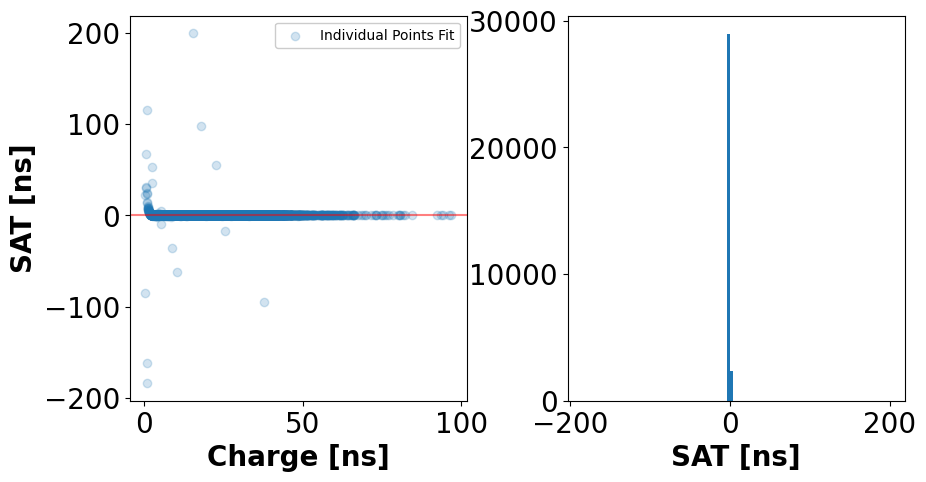

In [31]:
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_meases, cor_name in zip([indiv_params, med_bins_params, gaus_bins_params], cor_names):
    if cor_meases is None:
        print(f'{cor_name}: {cor_meases} is None, skipping')
        continue
    print(f'{cor_name}: {cor_meases}')
    cor_popt = [par.val for par in cor_meases]
    time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor, alpha=0.2, label=cor_name)
    axs[0].axhline(0, color='red', alpha=0.5)
    axs[0].set_xlabel('Charge [ns]')
    axs[0].set_ylabel('SAT [ns]')
    axs[1].hist(time_diff_cor, bins=100)
    axs[1].set_xlabel('SAT [ns]')
    axs[0].legend()
    fig.subplots_adjust(wspace=0.3)
    # Set ylim to 2nd and 98 percentile
    axs[0].set_ylim(np.percentile(time_diff_cor, 1), np.percentile(time_diff_cor, 99))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs, time_diff_cor, alpha=0.2, label=cor_name)
    ax.set_xlabel('Radial Distance [mm]')
    ax.set_ylabel('SAT [ns]')
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)

In [ ]:
df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['xy_cut'] & filters[mm_channel]['r_cut'] & filters[mm_channel]['saturation_cut']]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']

n_charge_bins = 100
charge_bins = np.percentile(charges, np.linspace(0, 100, n_charge_bins + 1))
charge_bins = [[charge_bins[i], charge_bins[i+1]]for i in range(len(charge_bins) - 1)]

time_diff_cors = {
    'Uncorrected': time_diff,
    'Corrected Median': time_diff - time_walk_func(charges, *[par.val for par in med_bins_params]),
    'Corrected Gaus': time_diff - time_walk_func(charges, *[par.val for par in gaus_bins_params]),
}
time_diff_cor_colors = {'Uncorrected': 'k', 'Corrected Median': 'm', 'Corrected Gaus': 'c'}
charge_scan_resolutions = {}

for cor_name, time_diff_cor_i in time_diff_cors.items():
    charge_reses, charge_means, charge_events = get_charge_scan(time_diff_cor_i, charges, charge_bins, ns_to_ps=True, percentile_cuts=(5, 95), plot=False)
    charge_scan_resolutions[cor_name] = charge_reses

In [ ]:
p0_resol = [100, 0.01, 50, 0.001, 10]
resol_func = time_walk_double_exponential
resol_vs_charge_popt = None
correction_to_use = 'Corrected Gaus'  # Correction to use moving forward

fig, ax = plt.subplots(figsize=(8, 5))

charge_bin_means, charge_bin_stds = [], []
for charge_bin in charge_bins:
    charge_bin_low, charge_bin_high = charge_bin
    mask = (charge_bin_low <= charges) & (charges < charge_bin_high)
    charge_bin_means.append(np.mean(charges[mask]))
    charge_bin_stds.append(np.std(charges[mask]))

for cor_name in time_diff_cors.keys():
    charge_res_vals = [x.val for x in charge_scan_resolutions[cor_name]]
    charge_res_errs = [x.err for x in charge_scan_resolutions[cor_name]]
    ax.errorbar(charge_bin_means, charge_res_vals, xerr=charge_bin_stds, yerr=charge_res_errs, ls='none', marker='.', color=time_diff_cor_colors[cor_name], label=cor_name, alpha=0.5)
    if cor_name == 'Corrected Gaus':
        xdata = np.array(charge_bin_means)
        ydata = np.array([x.val for x in charge_scan_resolutions['Corrected Gaus']])
        yerr = np.array([x.err for x in charge_scan_resolutions['Corrected Gaus']])

        popt, pcov = cf(resol_func, xdata, ydata, sigma=yerr, absolute_sigma=True, p0=p0_resol)

        if cor_name == correction_to_use:
            resol_vs_charge_popt = popt

        x_fit = np.linspace(min(xdata), max(xdata), 500)
        y_fit = resol_func(x_fit, *popt)

        ax.plot(x_fit, y_fit, 'r--', label='Double Exp Fit (Corrected Gaus)')
ax.set_ylim(bottom=0)
ax.legend()
ax.set_xlabel('Total Charge (pC)')
ax.set_ylabel('Time Resolution (ps)')

# Correct for timewalk for the best parameterization


# Get the time difference distribution in rings

In [ ]:
df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['xy_cut'] & filters[mm_channel]['saturation_cut']]
charges = df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge']
time_diff = df_filter[f'{mm_channel}_time_diff']
xs = df_filter[f'hitX_{mm_channel}']
ys = df_filter[f'hitY_{mm_channel}']
rs = df_filter[f'hitR_{mm_channel}']

# time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in indiv_params])
# time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in med_bins_params])
time_diff_cor = time_diff - time_walk_func(charges, *[x.val for x in gaus_bins_params])
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, time_diff_cor, alpha=0.2)
ax.set_xlabel('Radial Distance [mm]')
ax.set_ylabel('SAT [ns]')
ax.axhline(0, color='gray', zorder=0)
ax.set_ylim(-1.5, 1)

In [ ]:
r_bin_width = 2.5
r_bin_edges = np.arange(0, 8, r_bin_width)
center_x, center_y = mm_pad_center_measures[0].val, mm_pad_center_measures[1].val
get_ring_scan(time_diff_cor, r_bin_edges, r_bin_width, rs, percentile_cuts=(1,99), xs=xs, ys=ys, plot=True)

# Monitor the radial distribution of the charge

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs, charges, alpha=0.2)
ax.axhline(0, color='gray', zorder=0)
ax.axvline(r_inner, color='green', zorder=10)
ax.axvline(r_outer, color='orange', zorder=10)
ax.set_xlim(-1, 10)

# Get the time difference distribution in circles overlapping to get resolution and SAT map

In [ ]:
x_pad_center, y_pad_center = mm_pad_center_measures
scan_radius = 1.0  # mm Radius of scanning circle
min_events_per_circle = 350  # Minimum number of events per scan circle. If less, skip the step
xy_scan = mm_pad_center_measures
# Get center of pad
x_center = x_pad_center.val
y_center = y_pad_center.val
n_steps = 10
step_size = 2 * scan_radius / n_steps # 0.2mm
xs_scan = np.linspace(x_center - scan_radius, x_center + scan_radius, n_steps + 1)
ys_scan = np.linspace(y_center - scan_radius, y_center + scan_radius, n_steps + 1)
# y_scan = y_center - scan_radius
# xy_pairs = [(x, y_scan) for x in xs_scan]
xy_pairs = [(x, y) for x in xs_scan for y in ys_scan]  
scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs, ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

In [ ]:
y_values = sorted(set(y for x, y in xy_pairs))  # Extract unique y values

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

for y in y_values:
    # Extract the scan_resolutions corresponding to the current y value
    xs_for_y = [x-x_center for x, y_ in xy_pairs if y_ == y]  # x values corresponding to this y
    scan_resolutions_for_y = [scan_resolutions[i].val for i, (x, y_) in enumerate(xy_pairs) if y_ == y]
    scan_resolutions_for_y_err = [scan_resolutions[i].err for i, (x, y_) in enumerate(xy_pairs) if y_ == y]

    # Plot scan_resolutions against xs for this y value
    ax.errorbar(xs_for_y, scan_resolutions_for_y, yerr=scan_resolutions_for_y_err, ls='none', marker='o', label=f'y = {y:.2f} mm', alpha=0.5)

ax.set_xlabel('Distance from pad center in x [mm]')
ax.set_ylabel('Resolution (ps) ')
# ax.set_title('Scan Resolutions vs X values for different Y values')
ax.set_ylim(bottom=15)
ax.legend()
ax.grid(True)

x_values = sorted(set(x for x, y in xy_pairs))  # Extract unique y values

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

for x in x_values:
    # Extract the scan_resolutions corresponding to the current y value
    ys_for_x = [y-y_center for x_, y in xy_pairs if x_ == x]  # x values corresponding to this y
    scan_resolutions_for_x = [scan_resolutions[i].val for i, (x_, y) in enumerate(xy_pairs) if x_ == x]
    scan_resolutions_for_x_err = [scan_resolutions[i].err for i, (x_, y) in enumerate(xy_pairs) if x_ == x]

    # Plot scan_resolutions against xs for this y value
    ax.errorbar(ys_for_x, scan_resolutions_for_x, yerr=scan_resolutions_for_x_err, ls='none', marker='o', label=f'x = {x:.2f} mm', alpha=0.5)

ax.set_xlabel('Distance from pad center in y [mm]')
ax.set_ylabel('Resolution (ps)')
# ax.set_title('Scan Resolutions vs Y values for different X values')
ax.set_ylim(bottom=15)
ax.legend()
ax.grid(True)

In [ ]:
# y_values = sorted(set(y for x, y in xy_pairs))  # Extract unique y values

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

for y in y_values:
    # Extract the scan_resolutions corresponding to the current y value
    xs_for_y = [x-x_center for x, y_ in xy_pairs if y_ == y]  # x values corresponding to this y
    scan_means_for_y = [scan_means[i].val for i, (x, y_) in enumerate(xy_pairs) if y_ == y]
    scan_means_for_y_err = [scan_means[i].err for i, (x, y_) in enumerate(xy_pairs) if y_ == y]

    # Plot scan_resolutions against xs for this y value
    ax.errorbar(xs_for_y, scan_means_for_y, yerr=scan_means_for_y_err, ls='none', marker='o', label=f'y = {y:.2f} mm', alpha=0.5)

ax.set_xlabel('Distance from pad center in x [mm]')
ax.set_ylabel('SAT (ps) ')
# ax.set_title('Scan Resolutions vs X values for different Y values')
# ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)

# x_values = sorted(set(x for x, y in xy_pairs))  # Extract unique y values

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

for x in x_values:
    # Extract the scan_resolutions corresponding to the current y value
    ys_for_x = [y-y_center for x_, y in xy_pairs if x_ == x]  # x values corresponding to this y
    scan_means_for_y = [scan_means[i].val for i, (x_, y) in enumerate(xy_pairs) if x_ == x]
    scan_means_for_y_err = [scan_means[i].err for i, (x_, y) in enumerate(xy_pairs) if x_ == x]

    # Plot scan_resolutions against xs for this y value
    ax.errorbar(ys_for_x, scan_means_for_y, yerr=scan_means_for_y_err, ls='none', marker='o', label=f'x = {x:.2f} mm', alpha=0.5)

ax.set_xlabel('Distance from pad center in y [mm]')
ax.set_ylabel('SAT (ps)')
# ax.set_title('Scan Resolutions vs Y values for different X values')
# ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)

# Get the 2D heatmaps for timing resolution and SAT

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 15))
axs = axs.flatten()
angles = [0, 30, 45, 60, 90, 180, 240,270]  # degrees
for idx, angle in enumerate(angles):
    xy_pairs = generate_line_scan(x_center, y_center, scan_radius, n_steps, angle)

    scan_resolutions, scan_means, events = get_circle_scan(
        time_diff_cor, xs, ys, xy_pairs,
        radius=scan_radius,
        min_events=min_events_per_circle,
        ns_to_ps=True,
        percentile_cuts=(2, 98),
        plot=False
    )

    # Relative position along the line, in mm
    ts = np.linspace(-scan_radius, scan_radius, len(scan_means))  # line distances
    means = [m.val for m in scan_means]
    errors = [m.err for m in scan_means]

    ax = axs[idx]
    ax.errorbar(ts, means, yerr=errors, fmt='o', label=f"{angle}°", alpha=0.8)
    # ax.set_title(f"Mean vs. Position at {angle}°")
    # ax.set_xlabel("Relative position along scan line (mm)")
    ax.set_ylabel("SAT (ps)")
    ax.grid(True)
    ax.legend()

 # Remove all individual x-axis labels
    ax.set_xlabel("Relative Position along scan line")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 15))
axs = axs.flatten()
angles = [0, 30, 45, 60, 90, 180, 240,270]  # degrees
for idx, angle in enumerate(angles):
    xy_pairs = generate_line_scan(x_center, y_center, scan_radius, n_steps, angle)

    scan_resolutions, scan_means, events = get_circle_scan(
        charges, xs, ys, xy_pairs,
        radius=scan_radius,
        min_events=min_events_per_circle,
        ns_to_ps=True,
        percentile_cuts=(2, 98),
        plot=False
    )

    # Relative position along the line, in mm
    ts = np.linspace(-scan_radius, scan_radius, len(scan_means))  # line distances
    means = [m.val for m in scan_means]
    errors = [m.err for m in scan_means]

    ax = axs[idx]
    ax.errorbar(ts, means, yerr=errors, fmt='o', label=f"{angle}°", alpha=0.8)
    # ax.set_title(f"Mean vs. Position at {angle}°")
    # ax.set_xlabel("Relative position along scan line (mm)")
    ax.set_ylabel("Total charge (ps)")
    ax.grid(True)
    ax.legend()

    # Remove all individual x-axis labels
    ax.set_xlabel("Relative Position along scan line")

plt.tight_layout()
plt.show()

In [ ]:
n_steps_2D = 100
# Define scan ranges
# scan_xs = np.arange(20, 50, 0.5)
# scan_ys = np.arange(20, 50, 0.5)  # Define y range

scan_xs = np.linspace(x_center - r_outer * 2.0, x_center + r_outer * 2.0, n_steps_2D + 1)
scan_ys = np.linspace(y_center - r_outer * 2.0,  y_center + r_outer * 2.0, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs, ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius)


# 2D scan for the non corrected SAT

In [ ]:
scan_xs = np.linspace(x_center - r_outer * 2.0, x_center + r_outer * 2.0, n_steps_2D + 1)
scan_ys = np.linspace(y_center - r_outer * 2.0,  y_center + r_outer * 2.0, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

scan_resolutions, scan_means, events = get_circle_scan(time_diff, xs, ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius)

In [ ]:
# Write relevant event data to dataframe
out_df_path = f'scan_pad_dfs/Run{run_number}-Pool{pool_number}-{mm_channel}.csv'

df_filter = df[filters[mm_channel]['totcharge_cut'] & filters[mm_channel]['xy_cut'] & filters[mm_channel]['saturation_cut']].copy()

# Get corrected time difference and add to dataframe
time_diff = df_filter[f'{mm_channel}_time_diff']
cor_popt = [par.val for par in gaus_bins_params]

# Normalize to median of charges distribution
# time_diff_cor_norm = time_walk_func(np.median(charges), *cor_popt)
time_diff_cor_norm = 0
time_diff_cor = time_diff - time_walk_func(charges, *cor_popt) + time_diff_cor_norm
df_filter[f'{mm_channel}_time_diff_cor'] = time_diff_cor

# Get estimated time difference resolution and add to dataframe
df_filter[f'{mm_channel}_charge_time_res'] = resol_func(df_filter[f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge'], *resol_vs_charge_popt)

save_cols = {'SRSNo': 'SRSNo',
             f'hitX_{mm_channel}': 'hitX',
             f'hitY_{mm_channel}': 'hitY',
             f'peakparam_{mm_channel}/peakparam_{mm_channel}.totcharge': 'totcharge',
             f'{mm_channel}_time_diff': 'time_diff',
             f'{mm_channel}_time_diff_cor': 'time_diff_cor',
             f'{mm_channel}_charge_time_res': 'charge_time_res'}
df_filter = df_filter[list(save_cols.keys())]
df_filter = df_filter.rename(columns=save_cols)
df_filter.to_csv(out_df_path, index=False)

# Add pad centers to pad_centers dataframe
scan_pad_centers_df = f'scan_pad_dfs/scan_pad_centers.csv'
x_c, y_c = mm_pad_center_measures
update_pad_centers_csv(scan_pad_centers_df, run_number, pool_number, mm_channel, x_c.val, x_c.err, y_c.val, y_c.err)
